모두의 연구소 풀잎스쿨 - 캐글로 공부하는 데이터 분석 9주차 발표<br>
https://www.kaggle.com/hmendonca/fold1h4r3-arcenetb4-2-256px-rcic-lb-0-9759 의 코드를 리뷰한 내용입니다.

# 필요 라이브러리 import

In [1]:
from __future__ import print_function, division, absolute_import

%matplotlib inline
# %matplotlib notebook

import os, sys, gc
import numpy as np
import random
import glob

from tqdm import tqdm_notebook as tqdm

import torch
import ignite
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

from rcic_pytorch_utils import *  ## our utility script https://www.kaggle.com/hmendonca/rcic-pytorch-utils
# !cat rcic-pytorch-utils.py

## CNN
- [CNN 특징 추출 과정](https://yeo0.github.io/data/2018/10/05/CNN-%ED%8A%B9%EC%A7%95-%EC%B6%94%EC%B6%9C-%EA%B3%BC%EC%A0%95/)
![CNN과정](./image/CNN과정.PNG)

- Convolution Layer : 특징 추출
    - Convoltuion
    - Channel
    - Filter
    - Stride
    - Padding
    - Activation Function
    - Feature map(output)
- Pooling : Activation Map의 크기 줄임 + 강조 특징 추출
- Fully Connected Layer : classification

## 네트워크 hyperparameter 및 필요 변수 설정 
- 학습에 사용되는 hyperparameter들은 학습 시 연산되는 값이나 속도, 횟수와 연관
    - Learning rate : 모델 학습 속도
    - Epoch : 학습을 반복하는 횟수(forward pass + backward pass)
    - Batch size : Dataset을 작은 size로 나누는 크기(by 시스템 리소스)
    - Weight Decay : Overfitting을 피하기 위해 학습 속도 조절하는데 사용
    - Cost Function : 예측 값과 실제 값 차이

In [2]:
# seed 설정
fold = 1; head_num = 4; head_run = 3 # seed 설정 변수(fold, head_num, head_run 조합)
# f'fold{fold}h{head_num}r{head_run}_{best_epoch}_{scores[best_epoch]}.pth'
# fold1h4r2_1_0.6531595.pth

# Y
target = 'sirna_ct'

# 네트워크 hyperparameter
resolution = 256 # 이미지 resolution
dropout_rate = 0.4 # regularisation prior to ArcNet features
weight_decay = 2e-4 # SGD 설정
channel_size = 200 # ArcNet feature size(width, feature map)
margin = 0.45      # ArcNet margin, ArcNet 출력 
learning_rate = 0.035 # shceduler learning rate
warmup_learning_rate = learning_rate/100 # 초기 학습용 learning rate
focal_gamma = 3.5 # object detection에서 사용된 loss fuction

# 모델 설정 변수
remove_head = False # pretrained 사용여부, reset ArcNet head (features and fc layers)
train_to = -18  ## only train top half of the model
freeze_at_1st_n_last = False  # last layer를 제외하고 weights고정. freeze all but the last layers, at the first and last epoches

# device 설정 변수
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_amp = True if device == 'cuda' else False
training = True if device == 'cuda' else False
train_batch_size = 96 if device == 'cuda' else 16
eval_batch_size = 16 if device == 'cuda' else 8

# debug = is_interactive()
debug = False
create_sub = (device == 'cuda' or debug)

print(f'Interactive:{is_interactive()} Debug:{debug} Device:{device} Training:{training}')

Interactive:False Debug:False Device:cuda Training:True


미리 학습되어 있는 모델 path 설정

- Pseudo Labeling사용? 
    - submission.csv파일을 사용한 것으로 보아 이전에 제출한 데이터 결과를 기반으로 다시 학습한 것 같음<br>
- Semi-Supervised Learning
    - 사용이유 3가지
         1. 만들고자 하는 Model에 쓸, Traning data가 절대적으로 부족
         2. Large dataset이 될수록 새로 생성되는 data들에 대한 Human annotation(그림에 있는 사물/사람의 segmentation mask와 box 영역 등등)이 힘들고, 비쌀때
         3. <b><u>Labeled data만으로 도달할 수 있는 성능에 한계가 있을 때, Unlabelled data를 사용하여 전반적인 성능을 더 높이기 위해</u></b>

    - [Pseduo Labeling 참고](https://www.stand-firm-peter.me/2018/08/22/pseudo-label/)

In [3]:
# train모델과 pseudo label 경로 설정
path_data = '/kaggle/input/recursion-cellular-image-classification'
model_path = glob.glob(f'/kaggle/input/*/fold{fold}*.pth')[0]
best_sub = glob.glob(f'/kaggle/input/*/submission.csv')[0]

print(f'Training from model  {model_path}')
print(f'with pseudo labels from  {best_sub}')

Training from model  /kaggle/input/fold1h4r2-arcenetb4-2-256px-rcic/fold1h4r2_1_0.6531595.pth
with pseudo labels from  /kaggle/input/f1h4r2-hungarian-multi-norm-by-exp-pla/submission.csv


- random 변수 seed 설정

In [4]:
seed_everything(42000 + head_num*100 + head_run*10 + fold)

- 학습 및 테스트에 사용된 device 출력

In [5]:
print(torch.__version__, ignite.__version__, os.cpu_count())
if device == 'cuda': print(torch.cuda.get_device_name())

1.2.0 0.2.0 2
Tesla P100-PCIE-16GB


- Nvidia Apex
    - [Mixed Precision](https://hoya012.github.io/blog/Mixed-Precision-Training/) 연산을 위한 패키지를 만들었음. 
        - Mixed Precision? 보통은 32비트 연산을 하는데 16비트 연산을 사용해서 메모리를 절약하고 학습속도를 높이는 것
    - 효과
        1. 속도 향상
        2. 성능 비슷하거나 조금 향상
- apex 설명 :[참고1](https://cvml.tistory.com/8), [참고2](https://medium.com/daangn/pytorch-multi-gpu-%ED%95%99%EC%8A%B5-%EC%A0%9C%EB%8C%80%EB%A1%9C-%ED%95%98%EA%B8%B0-27270617936b)

In [6]:
# install NVIDIA Apex if needed to support mixed precision training
if use_amp and training:
    try:
        from apex import amp
    except ImportError:
#         !git clone https://github.com/NVIDIA/apex
#         !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" apex/
        !pip install  -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/*/*/NVIDIA-apex*
        from apex import amp

/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-xrrestam
Created temporary directory: /tmp/pip-req-tracker-8xrj45so
Created requirements tracker '/tmp/pip-req-tracker-8xrj45so'
Created temporary directory: /tmp/pip-install-bleob19k
Processing /kaggle/input/nvidia-apex/repository/NVIDIA-apex-880ab92
  Created temporary directory: /tmp/pip-req-build-unfaelkl
  Added file:///kaggle/input/nvidia-apex/repository/NVIDIA-apex-880ab92 to build tracker '/tmp/pip-req-tracker-8xrj45so'
    Running setup.py (path:/tmp/pip-req-build-unfaelkl/setup.py) egg_info for package from file:///kaggle/input/nvidia-apex/repository/NVIDIA-apex-880ab92
    Running command python setup.py egg_info
    torch.__version__  =  1.2.0
    running egg_info
    creating pip-

# Model : ArcNet(EfficientNet)

## EfficientNet : Rethinking Model Scaling for Convolutional Neural Networks 
- https://arxiv.org/abs/1905.11946
- [참고1](https://hoya012.github.io/blog/EfficientNet-review/), [참고2](https://www.youtube.com/watch?v=Vhz0quyvR7I&t=1907s), [참고3](https://hcshin.tistory.com/4)
- Google에서 ICML 2019학회에 제출한 논문으로 연산 비용과 파라미터 수를 낮춰 효율성을 높일 수 있는 방법/모델을 제안
- CNN을 확장하는 보다 원칙적인 방법

## Background
![Two Steams After ResNet](./image/TwoSteamsAfterResNet.PNG)
- FLOPS : 컴퓨터의 성능을 수치로 나타냄(초당 부동소수점 연산)
- ResNet 등장 이후, 사람의 인식 수준보다 더 높은 성능을 가지면서 CNN 모델은 2가지 방향으로 발전
    1. 더 높은 정확도 향상
    2. (성능보다)효율성을 높여서 좀 모델을 작게하면서도 비슷한 성능을 낼 수 있게하는 방법(연산비용 down)
- EfficientNet은 2가지 모두를 고려

## Model Scaling
- ConvNets를 Scaling-up and widely하여 더욱 좋은 성능을 보여줄 수 있음
- ConvNets를 Scaling-up하는 방법 3가지
    1. Depth : Layer의 개수 늘리기
    2. Width : Filter의 개수 늘리기
    3. Image resolution : input image 해상도 높이기
    
![Model Scaling](./image/ModelScaling.PNG)


- 기존 방식들에서는 3가지 scaling을 동시에 고려하는 경우가 거의 없었음
- 3가지 scaling 기법 중에 어떤 기법을 사용할지에 대해서도 마땅한 가이드라인이 존재하지 않음
- 위 논문에서는 <u>3가지 모두를 고려한 Compund Scaling(복합 모델링) 방법을 제안</u>

![Scalingup](./image/Scalingup.PNG)
- Width scaling, Depth Scaling 은 이른 시점에서 saturation되고 Resolution Scaling을 키울수록 정확도가 더 높아짐

## Compund Scaling
![Compound Scaling](./image/CompoundScaling.PNG)
- Depth(d)와 resolution(r)을 고정해두고 width만 조절하여 정확도 변화 측정
- 위의 그림을 보면 depth보다는 <u>resolution을 키우는 것이 정확도가 높음</u>
- 또한, 한 두가지를 올리는 것보다 <u>3가지 scaling factor를 동시에 키워주는 것이 가장 성능이 좋음</u> -> 동시에 키우는 것이 가장 좋다

## Compund Scaling Method
- Base line모델 선정(EfficientNet-B0)
    - <u>AutoML</u>을 통해 모델을 탐색(MnasNet과 거의 동일한 search space)
- <u>Base line 모델을 잘 선정해야하는 이유</u>
    - 위 논문에서는 모델(F)를 고정시키고 depth(d), width(w), resolution(r) 3가지를 조절
    - 초기 모델 자체 성능이 어느 정도 되어야 좋은 결과를 얻을 수 있음
    
![EfficientNet-B0](./image/EfficientNet-B0.PNG)

- Compund Method

![ScalingMethod](./image/SaclingMethod.PNG)
- 위의 알파, 베타, 감마를 찾는 방법
    - <u>Grid search</u>를 통해 구함
    - 처음 단계에서는 <u>파이를 1로 고정</u>한 뒤 타겟 데이터 셋에서 좋은 성능을 보이는 <u>알파, 베타, 감마 값을 찾아냄</u>
- 논문에서의 알파 값은 1.2, 베타 1.1, 감마 값은 1.15를 사용(본 코드에서의 값 각각 1.4, 1.8, 380(약1.7))
    - 파이는 하이퍼 파라미터 논문에서는 알파, 베타, 감마는 고정시키고 파이를 키워주며 모델 사이즈를 키움

## 결과
- 기존 ConvNet들에 비해 비슷한 정확도에 parameter수 및 FLOPS 수를 굉장히 절약
- ImageNet 데이터셋에서 가장 높은 정확도를 달성했던 GPipe 보다 더 높은 정확도 달성
- 더 정교한 CAM(Class Activation Map)
    - [CAM](https://jays0606.tistory.com/4) : CNN이 특정 클래스 이미지를 그 클래스라고 예측하게한 이미지내 위치 정보
        

Let's define some helpful modules:
- Flatten 
- Swish 

The reason why Swish is not implemented in `torch.nn` can be found [here](https://github.com/pytorch/pytorch/pull/3182).

- Activation Function - Swish
    - ReLU를 대체하기 위해 구글이 고안한 함수. 깊은 레이어를 학습시킬 때 ReLU보다 더 뛰어난 성능을 보여준다고 함.<br>
        - [참고1](https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820), [참고2](https://data-newbie.tistory.com/262)
- Properties of Swish
    - ?what?
    1. Unboundedness
        - Sigmoid, tanh 함수들과는 달리, swish는 <u>위로 경계가 없어</u> 때문에 0 근처 값을 가진 gradient를 유용하게 사용가능. 이러한 특징은 학습하는 동안 <u>0 근처 gradient 값이 포화되는 것을 막음</u>
    2. Smoothness of the curve
        - Smooth는 일반화와 최적화에 중요한 역할. Swish는 Smooth함수이므로 <u>ReLU와 달리 초기값과 Learning Rate에 덜 민감</u>
    3. Bounded Below
        - Swigh함수는 <u>하한이 있기 때문에 강한 Regularization 효과</u>를 줄 수 잇음

In [7]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)

Let's visualize Swish transform vs ReLU:

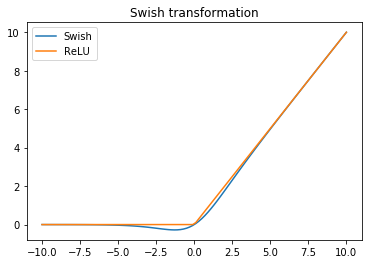

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

d = torch.linspace(-10.0, 10.0)
s = Swish()
res = s(d)
res2 = torch.relu(d)

plt.title("Swish transformation")
plt.plot(d.numpy(), res.numpy(), label='Swish')
plt.plot(d.numpy(), res2.numpy(), label='ReLU')
_ = plt.legend()

Now let's define `SqueezeExcitation` module

 SENet(Squeeze-and-Excitation Networks):
 - MBConv에 사용
 - https://wwiiiii.tistory.com/entry/SqueezeandExcitation-Networks
 - https://jayhey.github.io/deep%20learning/2018/07/18/SENet/
 - https://wiserloner.tistory.com/1242

- SENet
    - 채널 간의 상호작용을 학습한 뒤, 그 정보를 사용해 채널 단위로 새로운 가중치를 줘 성능 향상을 이끌어냄. 일종의 attention
        - ? what is attention?

- SE layer의 경우 순서
    - `Global avg 풀링 -> conv layer(fc layer) -> swish(ReLU) -> conv layer(fc layer) -> sigmoid`
- Recalibrate Channel only(채널만 재보정)
    - Global Average Pooling -> <u>Squeeze(각 채널의 중요한 정보만 추출)</u>
        - GAP 참고: https://gaussian37.github.io/dl-concept-global_average_pooling/
    - 채널축 conv layer(fc layer) -> <u>Excitation(옆의 채널과의 관계)(채널간 의존성 계산) </u>
- SE block의 장점
    1. <u>네트워크 어떤 곳이라도 바로 붙일 수 있음</u>. VGG, GoogLeNet, ResNet등 어느 네트워크에도 바로 부착이 가능
    2. 파라미터의 증가량에 비해 <u>모델 성능 향상도가 매우 큼</u>. 모델 복잡도와 계산 복잡도가 크게 증가하지 않는 다는 장점

In [9]:
class SqueezeExcitation(nn.Module):
    
    def __init__(self, inplanes, se_planes):
        super(SqueezeExcitation, self).__init__()
        self.reduce_expand = nn.Sequential(
            nn.Conv2d(inplanes, se_planes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(se_planes, inplanes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
        x_se = self.reduce_expand(x_se)
        return x_se * x


Next, we can define `MBConv`.

**Note on implementation**: in Tensorflow (and PyTorch ports) convolutions use `SAME` padding option which in PyTorch requires
a specific padding computation and additional operation to apply. We will use built-in padding argument of the convolution.

MBConv(Mobile inverted bottleneck convolution) 구조
- [MobileNetV2 and MobileNetV3](https://seongkyun.github.io/papers/2019/01/09/mobilenetv2/)
    - 계산량을 줄이면서(효율적 사용) 충분한 정보를 얻기 위한 구조
    - 채널 감소방식, 메모리 효율적
- Depthwise Convolution
    - 채널별 conv
    - 1x1 conv로 채널간 계산
- Squeeze-and-Excitation Networks

- [EfficientNet 모델 구조](https://lynnshin.tistory.com/13)

In [10]:
from torch.nn import functional as F

class MBConv(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, stride, 
                 expand_rate=1.0, se_rate=0.25, 
                 drop_connect_rate=0.2):
        super(MBConv, self).__init__()

        expand_planes = int(inplanes * expand_rate)
        se_planes = max(1, int(inplanes * se_rate))

        self.expansion_conv = None        
        if expand_rate > 1.0:
            self.expansion_conv = nn.Sequential(
                nn.Conv2d(inplanes, expand_planes, 
                          kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
                Swish()
            )
            inplanes = expand_planes

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(inplanes, expand_planes,
                      kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size // 2, groups=expand_planes,
                      bias=False),
            nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
            Swish()
        )

        self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(expand_planes, planes, 
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
        )

        self.with_skip = stride == 1
        self.drop_connect_rate = torch.tensor(drop_connect_rate, requires_grad=False)
    
    def _drop_connect(self, x):        
        keep_prob = 1.0 - self.drop_connect_rate
        drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
        drop_mask = drop_mask.type_as(x)
        drop_mask.floor_()
        return drop_mask * x / keep_prob
        
    def forward(self, x):
        z = x
        if self.expansion_conv is not None:
            x = self.expansion_conv(x)

        x = self.depthwise_conv(x)
        x = self.squeeze_excitation(x)
        x = self.project_conv(x)
        
        # Add identity skip
        if x.shape == z.shape and self.with_skip:            
            if self.training and self.drop_connect_rate is not None:
                self._drop_connect(x)
            x += z
        return x

And finally, we can implement generic `EfficientNet':

In [11]:
from collections import OrderedDict
import math


def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        
        
class EfficientNet(nn.Module):
        
    def _setup_repeats(self, num_repeats):
        return int(math.ceil(self.depth_coefficient * num_repeats))
    
    def _setup_channels(self, num_channels):
        num_channels *= self.width_coefficient
        new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
        new_num_channels = max(self.divisor, new_num_channels)
        if new_num_channels < 0.9 * num_channels:
            new_num_channels += self.divisor
        return new_num_channels

    def __init__(self, num_classes, 
                 width_coefficient=1.0,
                 depth_coefficient=1.0,
                 se_rate=0.25,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()
        
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.divisor = 8
                
        list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        list_channels = [self._setup_channels(c) for c in list_channels]
                
        list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
        list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
        
        expand_rates = [1, 6, 6, 6, 6, 6, 6]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

        # Define stem:
        self.stem = nn.Sequential(
            nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
            Swish()
        )
        
        # Define MBConv blocks
        blocks = []
        counter = 0
        num_blocks = sum(list_num_repeats)
        for idx in range(7):
            
            num_channels = list_channels[idx]
            next_num_channels = list_channels[idx + 1]
            num_repeats = list_num_repeats[idx]
            expand_rate = expand_rates[idx]
            kernel_size = kernel_sizes[idx]
            stride = strides[idx]
            drop_rate = drop_connect_rate * counter / num_blocks
            
            name = "MBConv{}_{}".format(expand_rate, counter)
            blocks.append((
                name,
                MBConv(num_channels, next_num_channels, 
                       kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                       se_rate=se_rate, drop_connect_rate=drop_rate)
            ))
            counter += 1
            for i in range(1, num_repeats):                
                name = "MBConv{}_{}".format(expand_rate, counter)
                drop_rate = drop_connect_rate * counter / num_blocks                
                blocks.append((
                    name,
                    MBConv(next_num_channels, next_num_channels, 
                           kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                           se_rate=se_rate, drop_connect_rate=drop_rate)                                    
                ))
                counter += 1
        
        self.blocks = nn.Sequential(OrderedDict(blocks))
        
        # Define head
        self.head = nn.Sequential(
            nn.Conv2d(list_channels[-2], list_channels[-1], 
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
            Swish(),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(list_channels[-1], num_classes)
        )

        self.apply(init_weights)
        
    def forward(self, x):
        f = self.stem(x)
        f = self.blocks(f)
        y = self.head(f)
        return y

**All EfficientNet models can be defined using the following parametrization:
```
# (width_coefficient, depth_coefficient, resolution, dropout_rate)
'efficientnet-b0': (1.0, 1.0, 224, 0.2),
'efficientnet-b1': (1.0, 1.1, 240, 0.2),
'efficientnet-b2': (1.1, 1.2, 260, 0.3),
'efficientnet-b3': (1.2, 1.4, 300, 0.3),
'efficientnet-b4': (1.4, 1.8, 380, 0.4),
'efficientnet-b5': (1.6, 2.2, 456, 0.4),
'efficientnet-b6': (1.8, 2.6, 528, 0.5),
'efficientnet-b7': (2.0, 3.1, 600, 0.5),
```    
Let's define and train the third last one: `EfficientNet-B4

## Dataflow

Let's setup the dataflow:
- load train and test datasets
- setup train/test <u>image transforms </u>
- setup train/test <u>data loaders</u>

According to the EfficientNet paper, authors borrowed training settings from other publications and the dataflow for CIFAR100 is the following(다른 데이터 셋팅을 가져와 사용):
- input images to the network during training are <u>resized to the model resolution</u>(모델에 맞게 resized)
- horizontally flipped randomly and augmented using cutout.(flip and augmentation 데이터량 증가)
- each mini-batch contained 256 examples(mini-batch 256)


In [12]:
import torchvision.utils as vutils

import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle

In [13]:
# 4가지 클래스를 숫자형으로 변환
le = preprocessing.LabelEncoder()
le.fit_transform(['HEPG2', 'HUVEC', 'RPE', 'U2OS']) 

array([0, 1, 2, 3])

In [ ]:
df = pd.read_csv(path_data+'/train.csv')
df['set'] = 'train' # train dataset 표시
df_test = pd.read_csv(path_data+'/test.csv')
df_test['set'] = 'test' # test dataset 표시
best = pd.read_csv(best_sub, index_col=0)

# set_index를 사용하여 'id_code'로 index 정렬, 같은 'id_code'를 가진 것들을 합침 
# test로 얻은 결과를 사용?
df_test_pseudo = df_test.set_index('id_code').join(best, how='inner').reset_index()
#df_test['sirna'] = pd.read_csv(best_sub).sirna ## add pseudo-labels from best known submission

# 데이터 로드
df_ctrl = pd.read_csv(path_data+'/train_controls.csv')
df_ctrl['set'] = 'train'
df_ctrl_test = pd.read_csv(path_data+'/test_controls.csv')
df_ctrl_test['set'] = 'test'
df_ctrl = pd.concat([df_ctrl, df_ctrl_test], ignore_index=False, sort=False)
del df_ctrl_test

n_targets = df.sirna.nunique() + df_ctrl.sirna.nunique() # 각 column에 sirna의 고유값 개수 총합(타겟의 총 개수) 

for d in [df, df_test, df_test_pseudo, df_ctrl]:
    d['cell_type'] = d.experiment.apply(lambda s: s[:-3]) # -숫자 제외
    d['cell_type_n'] = le.transform(d.cell_type) # 4가지 클래스 숫자형으로 변환
    if d is not df_test:
        # 나중에 모델에서 클래스 output은 ''%n_tartgets'
        # 따라서 'd.sirna'이 결과로 나옴
        # 왜 이렇게 만들까?
        d['sirna_ct'] = d.sirna + (d.cell_type_n * n_targets) 

n_classes = df.sirna_ct.nunique() + df_ctrl.sirna_ct.nunique()
print(n_targets, n_classes)

In [15]:
df_test_pseudo.shape

(19897, 9)

In [16]:
print('cell types:', df.cell_type.unique().tolist())
print('train experiments:\n', df.experiment.unique().tolist())
print('test experiments:\n', df_test.experiment.unique().tolist())

cell types: ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
train experiments:
 ['HEPG2-01', 'HEPG2-02', 'HEPG2-03', 'HEPG2-04', 'HEPG2-05', 'HEPG2-06', 'HEPG2-07', 'HUVEC-01', 'HUVEC-02', 'HUVEC-03', 'HUVEC-04', 'HUVEC-05', 'HUVEC-06', 'HUVEC-07', 'HUVEC-08', 'HUVEC-09', 'HUVEC-10', 'HUVEC-11', 'HUVEC-12', 'HUVEC-13', 'HUVEC-14', 'HUVEC-15', 'HUVEC-16', 'RPE-01', 'RPE-02', 'RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07', 'U2OS-01', 'U2OS-02', 'U2OS-03']
test experiments:
 ['HEPG2-08', 'HEPG2-09', 'HEPG2-10', 'HEPG2-11', 'HUVEC-17', 'HUVEC-18', 'HUVEC-19', 'HUVEC-20', 'HUVEC-21', 'HUVEC-22', 'HUVEC-23', 'HUVEC-24', 'RPE-08', 'RPE-09', 'RPE-10', 'RPE-11', 'U2OS-04', 'U2OS-05']


- EDA notebook과 비슷하게 metadata생성

- train 데이터 셋에서 validation 데이터 셋 나눔

validation experiments:
 ['HEPG2-07', 'HEPG2-03', 'HUVEC-16', 'HUVEC-12', 'HUVEC-08', 'HUVEC-04', 'RPE-07', 'RPE-03', 'U2OS-03']


id_code experiment  plate well  sirna    set cell_type  \
12341  HUVEC-05_1_J05   HUVEC-05      1  J05    268  train     HUVEC   
7951   HUVEC-01_1_L08   HUVEC-01      1  L08    606  train     HUVEC   
21319  HUVEC-13_1_O23   HUVEC-13      1  O23    163  train     HUVEC   
6057   HEPG2-06_2_N13   HEPG2-06      2  N13    542  train     HEPG2   
129    HEPG2-08_1_H16   HEPG2-08      1  H16    997   test     HEPG2   
10802  HUVEC-03_4_B08   HUVEC-03      4  B08   1103  train     HUVEC   
13308  HUVEC-06_1_B22   HUVEC-06      1  B22    981  train     HUVEC   
6211   HEPG2-06_3_H05   HEPG2-06      3  H05   1029  train     HEPG2   
33379   U2OS-01_1_K17    U2OS-01      1  K17    533  train      U2OS   

       cell_type_n  sirna_ct  
12341            1      1407  
7951             1      1745  
21319            1      1302  
6057             0       542  
129              0       997  
10802            1      2242  
13308            1      2120  
6211             0      1029  
33379            3      3950

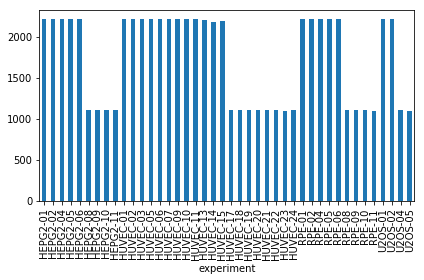

In [17]:
valid_experiments = get_fold(df, fold)
print('validation experiments:\n', valid_experiments)

# add 3/4 of validation to the training set to mimic effects of pseudo-labelling in tests set?
#df_train = df[~df.experiment.isin(valid_experiments) | (df.plate != fold)]
df_train = df[~df.experiment.isin(valid_experiments)]
df_valid = df[df.experiment.isin(valid_experiments)]

## add pseudo-labels to the oversampled training data (2/3)
# 오버샘플링을 통해 train dataset을 생성
df_train = pd.concat([df_train, df_train, df_test_pseudo], ignore_index=False, sort=False)

_ = df_train.groupby('experiment').id_code.count().plot(kind='bar') # 'id_code'별로 bar 그래프 형성
plt.tight_layout()

df_train.sample(9)

- Oversample minority classes in training
    - 가장 작은 클래스에 대해 oversampling하여 class balance를 맞춤

32


count    4432.000000
mean       16.468186
std         9.499475
min         5.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        32.000000
Name: sirna_ct, dtype: float64

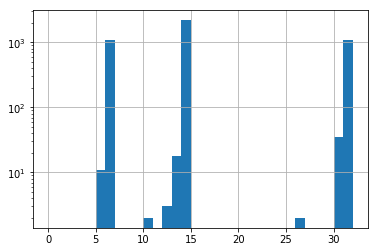

In [18]:
plt.yscale('log')
target_dist = df_train.groupby(target)[target].count()
max_n = target_dist.max()
print(max_n)

_ = target_dist.hist(bins=np.arange(max_n+1))
target_dist.describe()

- 'sirna_ct'를 그룹별로 나눠서 count한 것 중 개수가 가장 낮은 클래스를 oversampling 

In [19]:
if training or not debug:
    for label,n in target_dist.items():
        copies = min(int(round(max_n/n) - 1), 4)
        if copies != 0:
    #         print(f'label:{label} n:{n} copies:{copies}')
            addon = [df_train[df_train[target] == label]] * copies
            df_train = pd.concat([df_train] + addon, ignore_index=False, sort=False)

In [20]:
# show some copies
print(df_train.shape)
df_train[df_train.id_code == f'U2OS-0{5-fold}_1_D12']

(130583, 9)


id_code experiment  plate well  sirna   set cell_type  \
17739  U2OS-04_1_D12    U2OS-04      1  D12    182  test      U2OS   
17739  U2OS-04_1_D12    U2OS-04      1  D12    182  test      U2OS   
17739  U2OS-04_1_D12    U2OS-04      1  D12    182  test      U2OS   
17739  U2OS-04_1_D12    U2OS-04      1  D12    182  test      U2OS   
17739  U2OS-04_1_D12    U2OS-04      1  D12    182  test      U2OS   

       cell_type_n  sirna_ct  
17739            3      3599  
17739            3      3599  
17739            3      3599  
17739            3      3599  
17739            3      3599

count    4432.000000
mean       29.463673
std         1.675298
min        25.000000
25%        28.000000
50%        28.000000
75%        30.000000
max        36.000000
Name: sirna_ct, dtype: float64

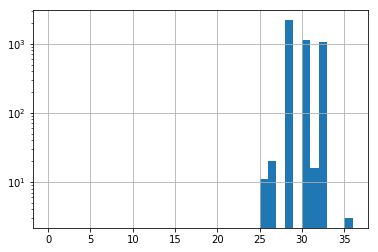

In [21]:
plt.yscale('log')
target_dist = df_train.groupby(target)[target].count()
_ = target_dist.hist(bins=np.arange(target_dist.max()+1))
target_dist.describe()

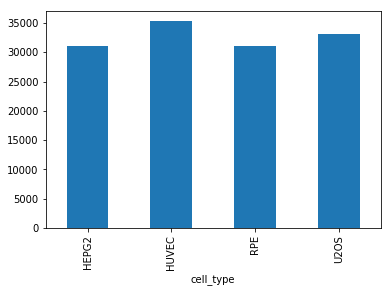

In [22]:
_ = df_train.groupby('cell_type').id_code.count().plot(kind='bar')

Add controls

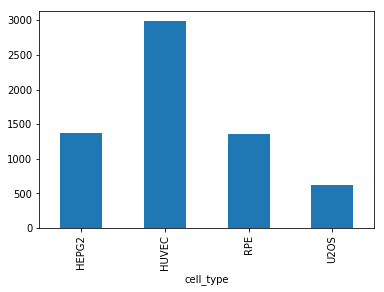

In [23]:
df_ctrl = df_ctrl[df_train.columns]
_ = df_ctrl.groupby('cell_type').id_code.count().plot(kind='bar')

- test나 validation의 experiment 데이터를 일부 포함시켜 줌(  to improve the type balance in the training set)

In [24]:
## train on some controls too. A different number per cell type is chosen to improve the type balance in the training set

# U2OS: add all controls
df_train = pd.concat([df_train, df_ctrl[(df_ctrl['cell_type_n'] == 4)]],
                     ignore_index=False, sort=False)
# RPE & HEPG2 controls from only one plate (each plate repeats the same controls again)
df_train = pd.concat([df_train, df_ctrl[(
    df_ctrl['cell_type_n'].isin([0,2])) & ((
    df_ctrl['plate'] != fold) | (
    df_ctrl.experiment.isin(df_test.experiment.unique()) | df_ctrl.experiment.isin(valid_experiments)))]],
                     ignore_index=False, sort=False)
# HUVEC only controls from test and validation
df_train = pd.concat([df_train, df_ctrl[(
    df_ctrl['cell_type_n'] == 1) & (
    df_ctrl['plate'] == fold) & (
    df_ctrl.experiment.isin(df_test.experiment.unique()) | df_ctrl.experiment.isin(valid_experiments))]],
                     ignore_index=False, sort=False)

count    4525.000000
mean       29.475801
std         2.469469
min        11.000000
25%        28.000000
50%        30.000000
75%        31.000000
max        45.000000
Name: sirna_ct, dtype: float64

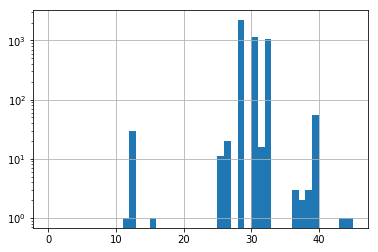

In [25]:
plt.yscale('log')
target_dist = df_train.groupby(target)[target].count()
_ = target_dist.hist(bins=np.arange(target_dist.max()+1))
target_dist.describe()

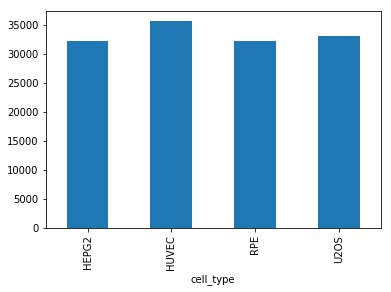

In [26]:
_ = df_train.groupby('cell_type').id_code.count().plot(kind='bar')

In [27]:
if debug:
    df_train = df_train[df_train[target].isin(df_train[target].sample(50))] # some random classes
    df_valid = df_valid[df_valid[target].isin(df_train[target].unique())]   # same classes

print(df_train.shape, df_valid.shape, df_test.shape)

(133378, 9) (9970, 9) (19897, 7)


Calculate class weights to balance loss function

- 학습을 원활히 시키기 위해 'sirna_ct' class에 weight를 추가<br>
개수가 많은 클래스일수록 weight를 적게주고 적은 개수의 클래스에는 큰 weight를 곱해줌
    - class_weights 들은 FocalLoss에 사용

In [28]:
class_weights = 1. / target_dist
class_weights *= n_classes / class_weights.sum()
# class_weights = class_weights**0.5  # smoothing non-linearity
class_weights.describe()

count    4525.000000
mean        1.006851
std         0.134513
min         0.652929
25%         0.947801
50%         0.979394
75%         1.049351
max         2.671075
Name: sirna_ct, dtype: float64

In [29]:
class_weights = class_weights.values.ravel() # ravel(): 배열 다차원 -> 1차열

Get pixels statistics by experiment

In [4]:
"""
def get_rcic_exp_stats(path_data):
    ''' Get pixel stats group by experiment '''
    stats = pd.read_csv(path_data+'/pixel_stats.csv')
    stats['var'] = stats['std']**2.
    exp_stats = stats.groupby(['experiment', 'channel']).mean()
    ## fix non-linear std
    exp_stats['std'] = np.sqrt(exp_stats['var'])
    return exp_stats
"""

"\ndef get_rcic_exp_stats(path_data):\n    ''' Get pixel stats group by experiment '''\n    stats = pd.read_csv(path_data+'/pixel_stats.csv')\n    stats['var'] = stats['std']**2.\n    exp_stats = stats.groupby(['experiment', 'channel']).mean()\n    ## fix non-linear std\n    exp_stats['std'] = np.sqrt(exp_stats['var'])\n    return exp_stats\n"

In [30]:
exp_stats = get_rcic_exp_stats(path_data) # pixel_stats.csv. Get pixel stats group by experiment
exp_stats.describe()

plate   site        mean         std      median         min  \
count  306.000000  306.0  306.000000  306.000000  306.000000  306.000000   
mean     2.499912    1.5    9.352168    7.307145    7.344359    1.739723   
std      0.000460    0.0    7.556980    5.138812    6.589153    1.438729   
min      2.497946    1.5    1.158154    1.284108    0.863231    0.000000   
25%      2.500000    1.5    4.519675    3.929292    3.246795    1.000406   
50%      2.500000    1.5    7.383960    5.866317    5.894481    1.151380   
75%      2.500000    1.5   11.364319    8.664639    9.238941    2.175963   
max      2.501219    1.5   55.510657   34.982736   47.766031   11.887987   

              max          var  
count  306.000000   306.000000  
mean   111.282655    79.715461  
std     51.737762   146.771862  
min     36.306006     1.648932  
25%     72.048600    15.439350  
50%     97.399351    34.413691  
75%    140.351867    75.076283  
max    254.998377  1223.791845

In [31]:
# is_interactive()가 True이므로 실행 X
if not is_interactive(): 
    del df; del df_ctrl; del target_dist
    gc.collect()

- Multi channel datatset normalised by experiment image stats
-  <u>'twin' image</u> is also selected from the same class from another random experiment
    - img와는 클래스가 같지만 다른 실험에서의 이미지 한 샘플 가져옴
- 학습 시에 twin 이미지를 사용

In [32]:
class ExpNormTwinDataset(Dataset):
    ''' Multi channel datatset normalised by experiment image stats
        During training, for every image a 'twin' image is also selected from the same class from another random experiment
    '''
    def __init__(self, df, img_dir, target, mode='train', sites=[1,2], channels=[1,2,3,4,5,6],
                 img_stats=None, transform=None):
        self.df = df
        self.channels = channels
        self.sites = sites
        self.target = target
        self.mode = mode
        self.img_dir = img_dir
        self.stats = img_stats
        self.transform = transform
        
    @staticmethod
    def _load_channel(file_name):
        img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
        return np.float32(img)

    def _get_img(self, rec, site):
        # rec = self.df.iloc[index]
        dset, experiment, well, plate = rec.set, rec.experiment, rec.well, rec.plate
        paths = [os.path.join(self.img_dir, dset, experiment, f'Plate{plate}', f'{well}_s{site}_w{channel}.png')
                 for channel in self.channels]
        img = [self._load_channel(img_path) for img_path in paths]

        ## norm
        if self.stats is not None:
            stats = self.stats.loc[experiment, ['mean', 'std']]
            # mean subtract
            img = [i-m for i,m in zip(img, stats['mean'].values)]
            # norm to 1 std
            img = [i/s for i,s in zip(img, stats['std'].values)]
        
        img = np.stack(img, axis=-1) # [N, W, H, C] 형태
#         print(stats)
#         print(img.shape, img.mean(axis=(1,0)).tolist(), img.std(axis=(1,0)).tolist(), float(img.min()), float(img.max()))
        if self.transform:
            img = self.transform(image=img)['image']
        return img
        
    def _get_twin(self, rec, site):
        experiment, target = rec.experiment, rec[self.target]
        twin = self.df[(self.df[self.target] == target) & (self.df.experiment != experiment)].sample(1).iloc[0]
        return self._get_img(twin, site)
        
    def __getitem__(self, index):
        rec = self.df.iloc[index]
        
        
        if self.mode == 'train':
            # returns a random site and a random twin
            
            # metadata에 담긴 정보에 매칭되는 image를 불러옴
            # site는 1 or 2중에 random으로 선택
            img = self._get_img(rec, random.choice(self.sites)) 
            
            # 위의 img와는 클래스가 같지만 다른 실험에서의 이미지 한 샘플 가져옴
            twin = self._get_twin(rec, random.choice(self.sites))
            return img, twin, rec[self.target]
        elif self.mode == 'eval':
            # returns a random site
            img = self._get_img(rec, random.choice(self.sites))
            return img, rec[self.target]
        elif self.mode == 'test':
            # returns raw images of all available sites
            return [self._get_img(rec, site) for site in self.sites]

    def __len__(self):
        """ Total number of samples in the dataset """
        return len(self.df)


In [33]:
from albumentations import *
from albumentations.pytorch import ToTensor

- Data augmentation and Dataset 설정

In [34]:
train_transform = Compose([
    Rotate(45, p=0.666), # 회전
#     GaussianBlur(blur_limit=3, p=0.5),
#     RandomBrightness(limit=0.01, p=0.5),
#     GaussNoise(var_limit=(0.001, 0.01), p=0.5),
#     OneOrOther(
#         RandomSizedCrop(min_max_height=np.int32([resolution*0.99, resolution*1.02]),
#                         height=resolution, width=resolution),
#     p=0.5),
    AverageCrop(resolution, resolution), # 이미지 일부 자르기
    HorizontalFlip(p=0.5), # 좌우 반전
    VerticalFlip(p=0.5), # 상하반전
    Transpose(p=0.5), # 채널 변환
    ToTensor(), # numpy에서 pytorch tensor 로 변환
])

valid_transform = Compose([
    CenterCrop(resolution, resolution),
    ToTensor(),
])


train_dataset = ExpNormTwinDataset(df_train, path_data, target=target, img_stats=exp_stats,
                                   mode='train', transform=train_transform)
train_eval_dataset = ExpNormTwinDataset(df_valid, path_data, target=target, img_stats=exp_stats,
                                   mode='eval', transform=valid_transform)

## TTA loaders
valid_dataset = ExpNormTwinDataset(df_valid, path_data, target=target, img_stats=exp_stats,
                                   mode='test', transform=ToTensor())
test_dataset = ExpNormTwinDataset(df_test, path_data, target=target, img_stats=exp_stats,
                                  mode='test', transform=ToTensor())

print(len(train_dataset), len(train_eval_dataset), len(valid_dataset), len(test_dataset))
print(test_dataset[0][0].shape, train_eval_dataset[0][0].shape, train_dataset[0][0].shape)

raw_image_size = test_dataset[0][1].shape[-1]
raw_image_size

133378 9970 9970 19897
torch.Size([6, 512, 512]) torch.Size([6, 256, 256]) torch.Size([6, 256, 256])


512

- train/val/test DataLoader 설정

In [35]:
from torch.utils.data import DataLoader

num_workers = os.cpu_count()
print('num_workers:', num_workers)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=num_workers, 
                          shuffle=True, drop_last=True, pin_memory=True)

eval_train_loader = DataLoader(train_eval_dataset, batch_size=eval_batch_size, num_workers=num_workers, 
                               shuffle=False, drop_last=False, pin_memory=True)

## TTA loaders
valid_loader = DataLoader(valid_dataset, batch_size=eval_batch_size, num_workers=num_workers, 
                               shuffle=False, drop_last=False, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=eval_batch_size, num_workers=num_workers, 
                         shuffle=False, drop_last=False, pin_memory=True)

print(len(train_loader), len(eval_train_loader), len(valid_loader), len(test_loader))

num_workers: 2
1389 624 624 1244


In [5]:
"""
def normalize_channels(img):
    _min, _max = img.min(axis=(0,1)), img.std(axis=(0,1))
    img = (img - _min) / (_max - _min)
    return img
"""

'\ndef normalize_channels(img):\n    _min, _max = img.min(axis=(0,1)), img.std(axis=(0,1))\n    img = (img - _min) / (_max - _min)\n    return img\n'

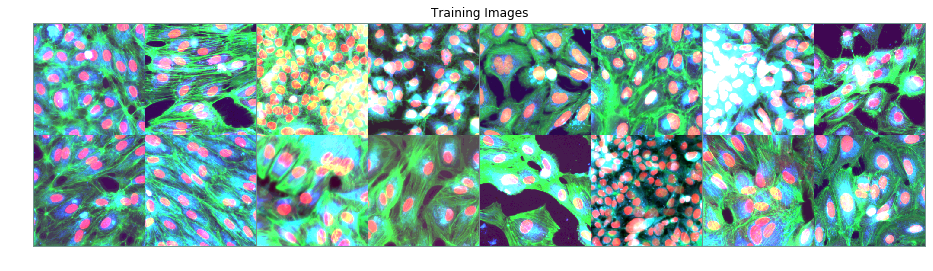

In [36]:
# Plot some training images
batch, twins, targets = next(iter(train_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images")
_ = plt.imshow( # show every second channel
    normalize_channels(
        vutils.make_grid(batch[:16,::2], padding=2, normalize=False).cpu().numpy().transpose((1, 2, 0)),
    )
)

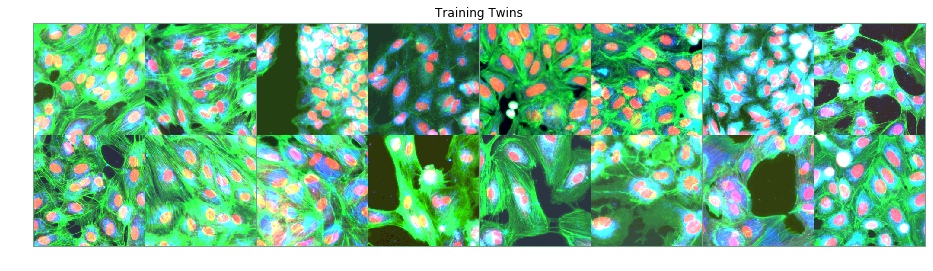

In [37]:
plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Twins")
_ = plt.imshow( # show every second channel
    normalize_channels(
        vutils.make_grid(twins[:16,::2], padding=2, normalize=False).cpu().numpy().transpose((1, 2, 0)),
    )
)

In [38]:
targets = targets[:16]
targets.reshape([len(targets)//8,8])

tensor([[1592, 1295,  610,  975, 4495, 4408,  221, 1990],
        [2005, 1187, 2732, 1795, 1219,  375, 2409, 4059]])

In [39]:
## mean should be around 0 and std around 1
{'mean':batch.mean(dim=(0,2,3)), 'std':batch.std(dim=(0,2,3))}

{'mean': tensor([0.0956, 0.1368, 0.2047, 0.1708, 0.1155, 0.2066]),
 'std': tensor([1.1082, 1.0915, 1.1034, 1.1208, 1.0612, 1.1090])}

In [40]:
del batch
torch.cuda.empty_cache() 
gc.collect()

4561

# Load pretrained weights

In [41]:
n_channels = len(test_dataset.channels)

- 파이토치 모델 weight들은 dict 형태로 불러와 load

In [42]:
def load_n_remap(model, model_path, device):
    model_state = torch.load(model_path, map_location=device)

    # A basic remapping is required
    mapping = { k:v for k,v in zip(model_state.keys(), model.state_dict().keys()) }
#         print(mapping)
    mapped_model_state = OrderedDict([
        (mapping[k], v) for k,v in model_state.items() if k in mapping.keys()
    ])

    model.load_state_dict(mapped_model_state, strict=False)
    return model

In [43]:
from collections import OrderedDict

## from: https://github.com/filipradenovic/cnnimageretrieval-pytorch

# 사용안함?
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)


# 사용안함?
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'


# EfficientNet 모델을 가져오는 함수
# Load된 모델의 stem 교체 및 head부분 삭제
# pretrained weights를 모델에 load
def get_model(model_path=None, n_classes=n_classes):
    model = EfficientNet(num_classes=n_classes, 
                         width_coefficient=1.4, depth_coefficient=1.8,
                         dropout_rate=dropout_rate)

    # fix n_channels
    orig_stem = model.stem[0]
    model.stem[0] = nn.Conv2d(
                      in_channels=n_channels,
                      out_channels=model.stem[0].out_channels,
                      kernel_size=model.stem[0].kernel_size,
                      stride=model.stem[0].stride,
                      padding=model.stem[0].padding,
                      bias=model.stem[0].bias)
#     model.stem[0].weight.data = F.interpolate(orig_stem.weight.data.unsqueeze(0),
#                                           size=[n_channels]+list(orig_stem.kernel_size),
#                                           mode='trilinear', align_corners=False)[0]

#     model.head[3] = GeM(p=1.25)
    # remove head.fc
    del model.head[6]

    if model_path is not None:
        model = load_n_remap(model, model_path, device)
    
    return model

In [44]:
### ArcNet from: https://github.com/pudae/kaggle-humpback/blob/master/tasks/identifier.py  
import types
import math


class ArcModule(nn.Linear):
    '''
        onehot output을 출력할 때 단순히 모델에서 나오는 출력이 아니라 출력 일부 처리
    '''
    def __init__(self, in_features, out_features, s, m):
        super().__init__(in_features=in_features, out_features=out_features, bias=False)
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, inputs, labels=None):
        cos_th = F.linear(inputs, F.normalize(self.weight))
        if labels is None:
            assert not self.training
            return cos_th * self.s
        cos_th = cos_th.clamp(-1, 1)
    
        ## add margin
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)

        ## truncate margin?
        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]

        ## add margin only to correct class
        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros_like(cos_th)
        onehot.scatter_(1, labels, 1)
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
        return outputs


class ArcNet(nn.Module):
    '''EfficientNet -> Linear layer -> Normalization -> feature로 forward'''
    def __init__(self, criterion, backbone, in_features, num_classes, channel_size, s=65, m=margin):
        super().__init__()
        assert num_classes % 2 == 0
        self.num_classes = num_classes
        self.criterion = criterion
        self.backbone = backbone
        self.feat = nn.Sequential(
            nn.Linear(in_features, channel_size, bias=False),
            nn.BatchNorm1d(channel_size, momentum=0.01),
        )
        self.arc = ArcModule(channel_size, num_classes, s=s, m=m)

    def features(self, images, labels=None):
        features = self.backbone(images)
        features = self.feat(features)
        features = F.normalize(features, dim=-1)
        return features

    def forward(self, images, twins=None, labels=None):
        
        if labels is None:
            features = self.features(images)
            return self.arc(features)
        else:
            return self.loss(images, twins, labels)

    # add additional cost to separate features according to their siRNA (not part of the original ArcNet)
    def loss(self, images, twins, labels, cos_w=3):
        f0 = self.features(images)
        f1 = self.features(twins)
        targets = (labels % n_targets)
        same_target = targets.expand(size=(len(targets), len(targets)))
        
        # images와 twins이 같은 이미지일 경우 같게 다를 경우는 다르게 판단하는지 안하는지에 대한 결과에
        # 대해 더 가중치를 주기 위해서???? twin 사용?
        same_target = 2*(same_target == same_target.t()).type_as(f0) - 1  ## 1 for equal targets and -1 for different ones
        cos_dist = 1 - (torch.mm(f0, f1.t()) * same_target)
        cos_dist = cos_dist**2  ## squared dist to focus on large errors
        loss = cos_w * (torch.mean(cos_dist)) # + torch.diag(cos_dist).mean())  ## additional cost for twins (diagonal)
        pred0 = self.arc(f0, labels)
        pred1 = self.arc(f1, labels)
        return loss + 0.5 * (self.criterion(pred0, labels) + self.criterion(pred1, labels))

In [1]:
"""
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2., reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha) if alpha is not None else None
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        if self.alpha is not None:
            self.alpha = self.alpha.type(inputs.type(), non_blocking=True) # fix type and device
            alpha = self.alpha[targets]
        else:
            alpha = 1.

        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = alpha * (1-pt)**self.gamma * CE_loss

        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()
        return F_loss
"""

"\nclass FocalLoss(nn.Module):\n    def __init__(self, alpha=None, gamma=2., reduction='mean'):\n        super(FocalLoss, self).__init__()\n        self.alpha = torch.tensor(alpha) if alpha is not None else None\n        self.gamma = gamma\n        self.reduction = reduction\n"

- Focal Loss 
    - Object Detection 의 한 종류인 retinanet에 쓰인 loss function
    - 잘 찾은 class에 대해서는 loss를 적게 줘 loss를 갱신 못하게 하고 잘 찾지 못한 class에 대해서는 loss를 크게 주어 loss 갱신을 크게 함
    - [참고1](https://wordbe.tistory.com/entry/ML-Cross-entropyCategorical-Binary%EC%9D%98-%EC%9D%B4%ED%95%B4), [참고2](https://ufris.tistory.com/17)
- ArcNet
    - EfficientNet -> Linear layer -> Normalization -> feature 

In [45]:
backbone = get_model(model_path if remove_head else None, n_classes)
model = ArcNet(criterion=FocalLoss(gamma=focal_gamma, alpha=class_weights),
               backbone=backbone, # Pretrained EfficientNet 
               in_features=backbone.head[0].out_channels, # 1280
               num_classes=n_classes, # 4556
               channel_size=channel_size # 200)
if not remove_head:
    model = load_n_remap(model, model_path, device)

In [46]:
# batch = next(iter(train_loader))
# with torch.no_grad():
#     print(model.to(device).loss(batch[0].to(device), batch[1].to(device), batch[2].to(device)))
# del batch

stem weight들을 plot

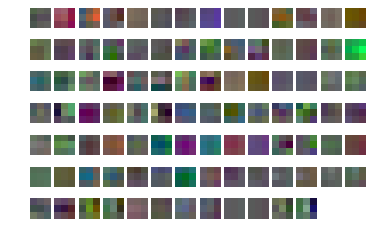

In [47]:
plot_first_kernels(model.backbone.stem[0].weight)

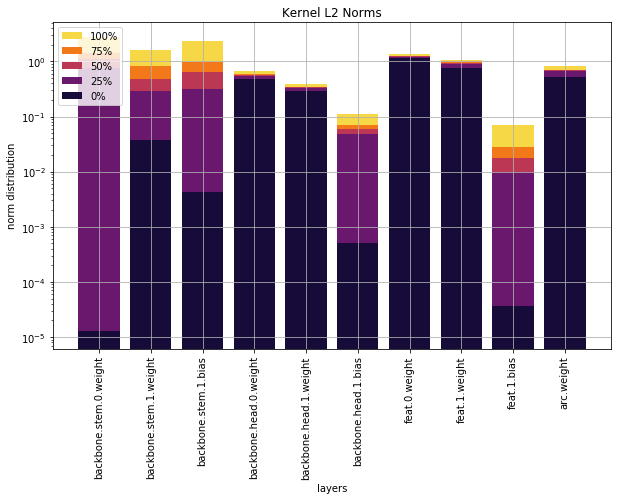

In [48]:
# check norms
plot_norms([(n,p) for n,p in model.named_parameters() if 'blocks' not in n])

In [49]:
model

ArcNet(
  (criterion): FocalLoss()
  (backbone): EfficientNet(
    (stem): Sequential(
      (0): Conv2d(6, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Swish()
    )
    (blocks): Sequential(
      (MBConv1_0): MBConv(
        (depthwise_conv): Sequential(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Swish()
        )
        (squeeze_excitation): SqueezeExcitation(
          (reduce_expand): Sequential(
            (0): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (1): Swish()
            (2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (3): Sigmoid()
          )
        )
        (project_conv): Sequential(
          (0): Conv2d(48, 24, kernel_size=(1, 1), st

We will finetune the model on GPU with AMP fp32/fp16 using nvidia/apex package.

finetune device 설정

In [50]:
if device == "cuda":
    assert torch.cuda.is_available()
    assert torch.backends.cudnn.enabled, "NVIDIA/Apex:Amp requires cudnn backend to be enabled."
    torch.backends.cudnn.benchmark = True

model = model.to(device)

all-mean: 0.9995255 twins-mean: 0.4187482198079427


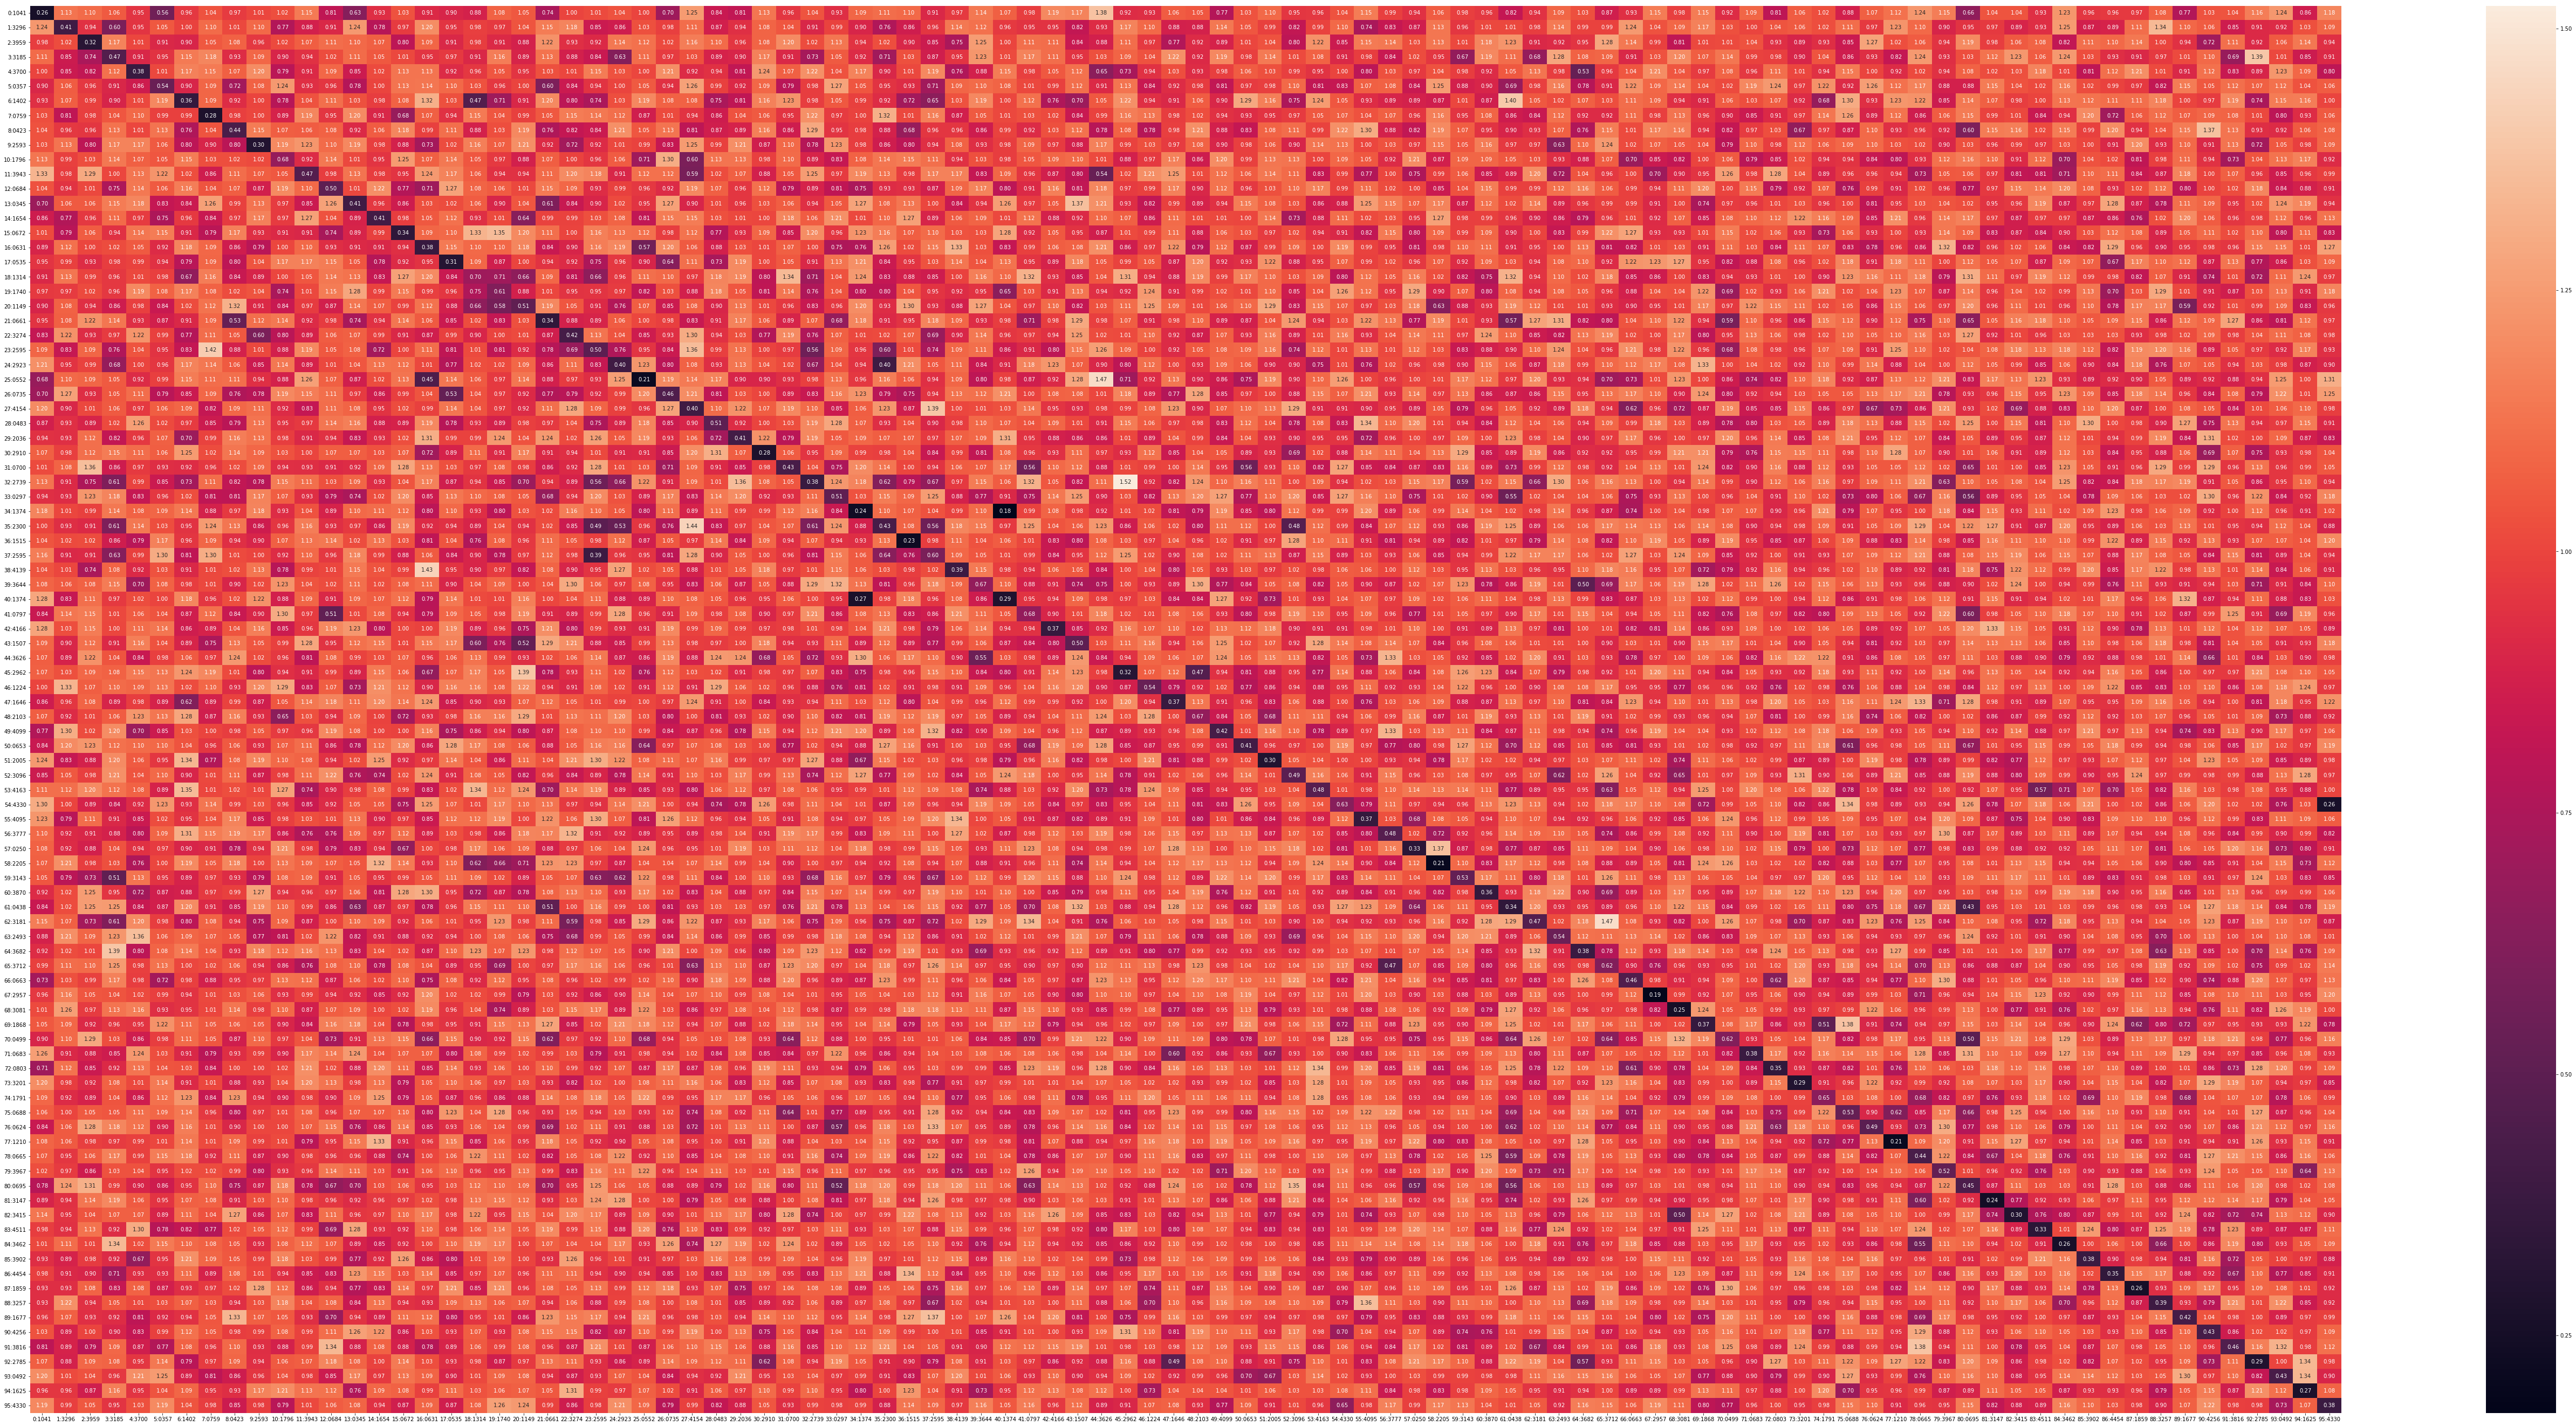

309436

In [51]:
# Check cosine distance between features
if training and not debug: cosine_distance_heatmap(model, next(iter(train_loader)))

torch.cuda.empty_cache()
gc.collect()

# Training
Let's setup focal loss as criterion and SGD as optimizer.

We will split model parameters into 3 groups: 
(모델 파라미터를 3그룹으로 나눔)

    1) feature extractor (pretrained weights)
    2) ArcNet normalised features
    3) classifier

and define different learning rates for these groups (via learning rate scheduler).
- pretrained weights로 feature를 추출하고 ArcNet으로 feature를 norm 그리고 최종적으로 classify

- free(weights 고정) 설정(절반옵션)
- SGD with scheduler 설정

In [52]:
from itertools import chain

import torch.optim as optim
import torch.nn.functional as F

lr = warmup_learning_rate

## Only train layers after the last dimension reduction to same memory + time
if train_to:
    ## train_to = 18 # only train top half of the model
    training_blocks = model.backbone.blocks[train_to:].parameters()
else:
    training_blocks = chain(model.backbone.stem.parameters(), model.backbone.blocks.parameters())

## freeze first layers prior to the warm-up run
params2freeze = None
if freeze_at_1st_n_last:
    params2freeze = chain(model.backbone.stem.named_parameters(), model.backbone.blocks.named_parameters())
elif train_to:
    params2freeze = chain(model.backbone.stem.named_parameters(), model.backbone.blocks[:train_to].named_parameters())

# layer의 반정도만 학습
if params2freeze is not None:
    for name, param in params2freeze:
        print(f'"{name}" is frozen')
        param.requires_grad = False


# 각 layer에 learning rate 세팅
optimizer = optim.SGD([
    {   "params": training_blocks,
        "lr": lr * 0.01,
    },
    {   "params": chain(model.feat[0].parameters(), model.backbone.head.parameters()),
        "lr": lr * 0.2,
    },
    {   "params": chain(model.feat[1].parameters(), model.arc.parameters()),
        "lr": lr
    }], 
    momentum=0.9, weight_decay=1e-6, nesterov=True)

# if not use_amp and head_run > 1: optimizer = Lookahead(optimizer)

"0.weight" is frozen
"1.weight" is frozen
"1.bias" is frozen
"MBConv1_0.depthwise_conv.0.weight" is frozen
"MBConv1_0.depthwise_conv.1.weight" is frozen
"MBConv1_0.depthwise_conv.1.bias" is frozen
"MBConv1_0.squeeze_excitation.reduce_expand.0.weight" is frozen
"MBConv1_0.squeeze_excitation.reduce_expand.0.bias" is frozen
"MBConv1_0.squeeze_excitation.reduce_expand.2.weight" is frozen
"MBConv1_0.squeeze_excitation.reduce_expand.2.bias" is frozen
"MBConv1_0.project_conv.0.weight" is frozen
"MBConv1_0.project_conv.1.weight" is frozen
"MBConv1_0.project_conv.1.bias" is frozen
"MBConv1_1.depthwise_conv.0.weight" is frozen
"MBConv1_1.depthwise_conv.1.weight" is frozen
"MBConv1_1.depthwise_conv.1.bias" is frozen
"MBConv1_1.squeeze_excitation.reduce_expand.0.weight" is frozen
"MBConv1_1.squeeze_excitation.reduce_expand.0.bias" is frozen
"MBConv1_1.squeeze_excitation.reduce_expand.2.weight" is frozen
"MBConv1_1.squeeze_excitation.reduce_expand.2.bias" is frozen
"MBConv1_1.project_conv.0.weight"

In [53]:
if use_amp and training:
    # Initialize Amp, nvidia apex
    model, optimizer = amp.initialize(model, optimizer, opt_level="O2", num_losses=1)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


Next, let's define a single iteration function `update_fn`. This function is then used by `ignite.engine.Engine` to update model while running over the input data.

## ignite

In [54]:
from ignite.utils import convert_tensor


def update_fn(engine, batch):
    x0 = convert_tensor(batch[0], device=device, non_blocking=True)
    x1 = convert_tensor(batch[1], device=device, non_blocking=True)
    y  = convert_tensor(batch[2], device=device, non_blocking=True)

    model.train()

    # Compute loss 
    loss = model(x0, x1, y)

    optimizer.zero_grad()
    if use_amp:
        # nvidia apex
        with amp.scale_loss(loss, optimizer, loss_id=0) as scaled_loss:
            scaled_loss.backward()
    else:
        loss.backward()
    optimizer.step()
    
    return {
        "batchloss": loss.item(),
    }    

Let's check `update_fn` and warmup the optimizer momentum

In [55]:
warmup_iters = 1 + (3.5 * n_targets) // train_batch_size
# if hasattr(optimizer, 'k'): warmup_iters -= (warmup_iters % optimizer.k)  ## complete look ahead iteration

print(int(warmup_iters))
torch.cuda.empty_cache()
gc.collect()

if training:
    loss = []
    loader = iter(train_loader)
    pbar = tqdm(range(2 if debug else int(warmup_iters)))
    for i in pbar:
        res = update_fn(engine=None, batch=next(loader))
        loss.append(res['batchloss'])
        pbar.set_description(f"loss:{loss[-1]:.4f}"); pbar.refresh()

    if device == 'cuda': print('max_memory_allocated:', torch.cuda.max_memory_allocated())
    torch.cuda.empty_cache()
    gc.collect()
    print('mean loss:', np.mean(loss))

42


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0

max_memory_allocated: 14266740736
mean loss: 14.138206845238095


Now let's define a trainer and add some practical handlers:
- log to tensorboard: losses, metrics, lr
- progress bar
- models/optimizers checkpointing

In [56]:
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import RunningAverage, Accuracy, Precision, Recall, Loss, TopKCategoricalAccuracy

from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

In [57]:
trainer = Engine(update_fn)

def siRNAaccuracyMax1108(pred, y):
    " Check predictions only on classes present in the validation and test sets "
    pred_ = pred.reshape([pred.shape[0], n_classes // n_targets, n_targets]).max(dim=1).values
    pred_ = torch.argmax(pred_[...,:1108], dim=-1)
    y_    = (y % n_targets)
    assert pred_.shape == y_.shape
    return (pred_ == y_).float().mean().cpu().numpy()

metrics = {
#     'Loss': Loss(criterion),
    'Score': Loss(siRNAaccuracyMax1108),
    'Accuracy': Accuracy(),
#     'Precision': Precision(average=True),
#     'Recall': Recall(average=True),
    'Top5Accuracy': TopKCategoricalAccuracy(k=5),
}

evaluator = create_supervised_evaluator(model, metrics=metrics, device=device, non_blocking=True)

history = Metrics(evaluator, eval_train_loader, output_transform=lambda out: out['batchloss'], interactive=is_interactive())
history.attach(trainer, "batchloss")

In [58]:
from datetime import datetime

log_path = f"./log"
tb_logger = TensorboardLogger(log_dir=log_path)

tb_logger.attach(trainer, 
                 log_handler=OutputHandler('training', ['batchloss', ]), 
                 event_name=Events.ITERATION_COMPLETED)

Let's setup learning rate scheduling:

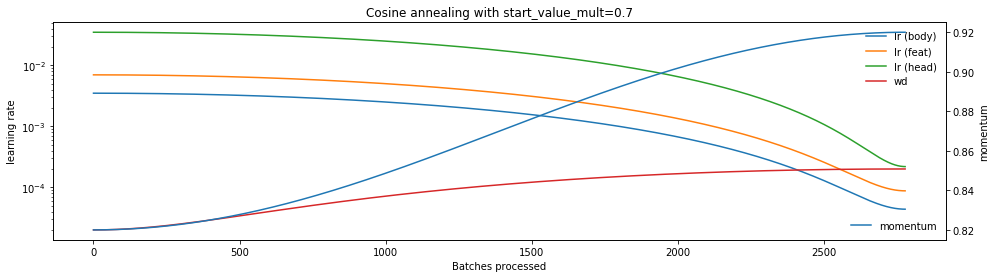

In [59]:
from ignite.contrib.handlers import CosineAnnealingScheduler, LinearCyclicalScheduler, ParamGroupScheduler

sim_epochs = 2
epoch_size = len(train_loader)
cycle_mult = 1
lr_sched_params = {'param_name':'lr', 'cycle_size':epoch_size*2, 'cycle_mult':cycle_mult,
                   'start_value_mult':0.7, 'end_value_mult':0.5}
mom_sched_params = {'param_name':'momentum', 'cycle_size':epoch_size*2, 'cycle_mult':cycle_mult,
                    'start_value':0.82, 'end_value':0.92}
wd_sched_params = {'param_name':'weight_decay', 'cycle_size':epoch_size*sim_epochs, 'cycle_mult':cycle_mult,
                   'start_value':weight_decay/10, 'end_value':weight_decay}

lr = learning_rate
body_sched_params = {**lr_sched_params, 'start_value':lr/10, 'end_value':lr/(100*2**head_run)}
body_sched = CosineAnnealingScheduler(optimizer.param_groups[0], **body_sched_params)
feat_sched_params = {**lr_sched_params, 'start_value':lr/5, 'end_value':lr/(50*2**head_run)}
feat_sched = CosineAnnealingScheduler(optimizer.param_groups[1], **feat_sched_params)
head_sched_params = {**lr_sched_params, 'start_value':lr, 'end_value':lr/(20*2**head_run)}
head_sched = CosineAnnealingScheduler(optimizer.param_groups[2], **feat_sched_params)

mom_sched = CosineAnnealingScheduler(optimizer, **mom_sched_params)
wd_sched  = CosineAnnealingScheduler(optimizer, **wd_sched_params)
schedulers = [body_sched, feat_sched, head_sched, mom_sched, wd_sched]
names = ["lr (body)", "lr (feat)", "lr (head)", "momentum", "wd"]

lr_values0 = np.array(body_sched.simulate_values(num_events=epoch_size*sim_epochs, **body_sched_params))
lr_values1 = np.array(feat_sched.simulate_values(num_events=epoch_size*sim_epochs, **feat_sched_params))
lr_values2 = np.array(head_sched.simulate_values(num_events=epoch_size*sim_epochs, **head_sched_params))
wd_values  = np.array(  wd_sched.simulate_values(num_events=epoch_size*sim_epochs, **wd_sched_params))
mom_values = np.array(mom_sched.simulate_values(num_events=epoch_size*sim_epochs, **mom_sched_params))

fig = plt.figure(figsize=(16, 4))
ax = plt.subplot()
plt.title(f"Cosine annealing with start_value_mult={lr_sched_params['start_value_mult']}")
ax.plot(lr_values0[:, 0], lr_values0[:, 1], label=names[0])
ax.plot(lr_values1[:, 0], lr_values1[:, 1], label=names[1])
ax.plot(lr_values2[:, 0], lr_values2[:, 1], label=names[2])
ax.plot( wd_values[:, 0],  wd_values[:, 1], label=names[4])
ax.set_yscale('log')
ax.set_xlabel('Batches processed')
ax.set_ylabel("learning rate")
ax.legend(frameon=False, loc='upper right')
ax2 = ax.twinx()
ax2.plot(mom_values[:, 0], mom_values[:, 1], label=names[3])
ax2.set_ylabel("momentum")
ax2.legend(frameon=False, loc='lower right')
# fig.tight_layout()
_ = ax.plot()

In [60]:
scheduler = ParamGroupScheduler(schedulers=schedulers, names=names)

# Attach single scheduler to the trainer
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

In [61]:
# Log optimizer parameters
tb_logger.attach(trainer,
                 log_handler=OptimizerParamsHandler(optimizer, "lr"), 
                 event_name=Events.EPOCH_STARTED)

In [62]:
from ignite.contrib.handlers import ProgressBar

# Iteration-wise progress bar
pbar = ProgressBar(bar_format="")
pbar.attach(trainer, metric_names=['batchloss',])

# Epoch-wise progress bar with display of training losses
ProgressBar(persist=True, bar_format="").attach(trainer,
                                                event_name=Events.EPOCH_STARTED,
                                                closing_event_name=Events.COMPLETED)

In [63]:
# Log validation metrics:
tb_logger.attach(evaluator,
                 log_handler=OutputHandler(tag="test",
                                           metric_names=list(metrics.keys()),
                                           another_engine=trainer),
                 event_name=Events.EPOCH_COMPLETED)

Now let's setup logging and the best model checkpointing:

## Logging

In [64]:
import logging

# Setup engine &  logger
def setup_logger(logger):
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s %(name)-12s %(levelname)-8s %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [65]:
from ignite.handlers import ModelCheckpoint, EarlyStopping, TerminateOnNan

trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

# Store the best model
def default_score_fn(engine):
    score = engine.state.metrics['Score']
    return score

best_model_handler = ModelCheckpoint(dirname=log_path,
                                     filename_prefix="best",
                                     n_saved=10,
                                     score_name="Score",
                                     score_function=default_score_fn,
                                     require_empty=False)
evaluator.add_event_handler(Events.COMPLETED, best_model_handler, {'model': model, })

# Clear cuda cache between training/testing
@trainer.on(Events.EPOCH_COMPLETED)
@evaluator.on(Events.COMPLETED)
def empty_cuda_cache(engine):
    if debug and device == 'cuda': print('max_memory_allocated:', torch.cuda.max_memory_allocated())
    torch.cuda.empty_cache()
    gc.collect()

In [66]:
# @trainer.on(Events.ITERATION_STARTED)
# def apply_weight_decay(engine):
#     with torch.no_grad():
#         for mod in model.modules():
#             if not isinstance(mod, nn.modules.batchnorm._BatchNorm):
#                 for p in mod.parameters():
#                     p.data -= p.data * weight_decay * lr

In [67]:
NUM_EPOCHS = (4 if debug else sim_epochs)

if freeze_at_1st_n_last:
    @trainer.on(Events.EPOCH_STARTED)
    def turn_on_layers(engine):
        epoch = engine.state.epoch
        ## first and last epoch
        if (epoch == 1) or (epoch == NUM_EPOCHS):
            for name, param in model.named_parameters():
                if ('backbone' not in name) or ('head' in name):
                    pbar.log_message(f'training "{name}"')
                    param.requires_grad = True
                else:
    #                 pbar.log_message(f'"{name}" is frozen')
                    param.requires_grad = False
        elif (epoch == 2):
            count = 0
            for param in training_blocks:  # only re-enable blocks, as head is already training
                if param.requires_grad == False:
                    param.requires_grad = True
                    count += 1
            pbar.log_message(f"Epoch {epoch}: training all layers ({count})")

In [68]:
if training:
    state = trainer.run(train_loader, max_epochs=NUM_EPOCHS)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



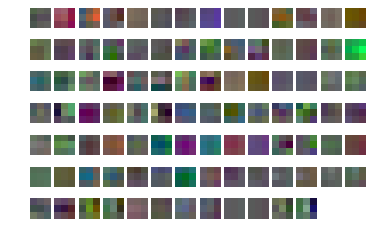

In [69]:
if training: plot_first_kernels(model.backbone.stem[0].weight)

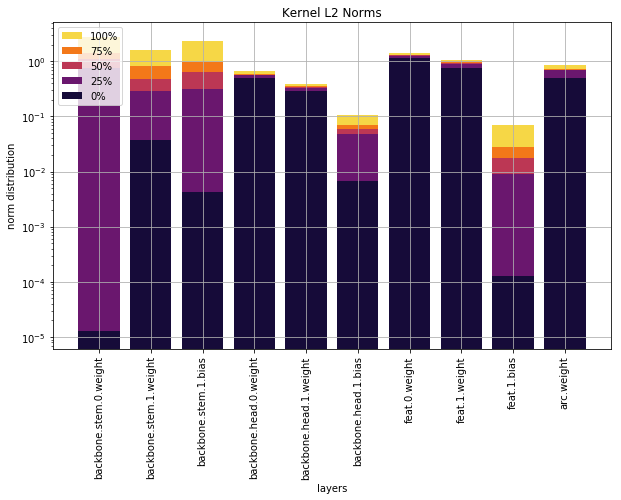

In [70]:
# check norms
if training: plot_norms([(n,p) for n,p in model.named_parameters() if 'blocks' not in n])

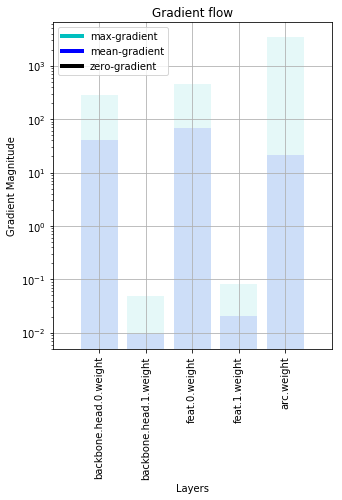

In [71]:
# check gradients (last batch)
if training: plot_grad_flow([(n,p) for n,p in model.named_parameters() if 'blocks' not in n])

Results on the validation set:

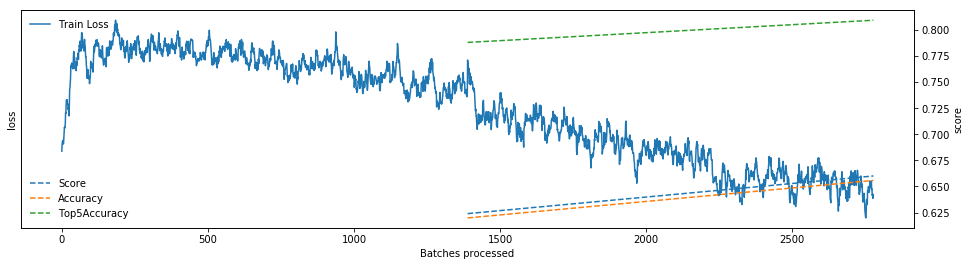

In [72]:
if training: 
    history.plot(len(train_loader))
    plt.savefig(f'loss_history{evaluator.state.epoch}_fold{fold}.png')
    evaluator.state.metrics

# Inference : 학습된 model을 사용하여 입력에 대한 답 추론

Let's load the best model and recompute evaluation metrics on test dataset with a very basic Test-Time-Augmentation to boost the performance

In [73]:
best_model = model

- best model을 찾음

In [74]:
# Find the last checkpoint
!ls {log_path}
checkpoints = next(os.walk(log_path))[2]
checkpoints = sorted(filter(lambda f: f.endswith(".pth"), checkpoints))
scores = [c.split('=')[-1][:-4] for c in checkpoints]
best_epoch = 0
if len(scores) > 0:
    best_epoch = np.argmax(scores)
    print(best_epoch, scores)
    if not checkpoints:
        print('No weight files in {}'.format(log_path))
    else:
        model_path = f'fold{fold}h{head_num}r{head_run}_{best_epoch}_{scores[best_epoch]}.pth'
        !cp {os.path.join(log_path, checkpoints[best_epoch])} {model_path}
        best_model.load_state_dict(torch.load(model_path))

print(model_path)

if not is_interactive():
    !rm {log_path}/*.pth

best_model_1_Score=0.6239719.pth  events.out.tfevents.1569441936.60ddcff70ff0
best_model_2_Score=0.6600802.pth
1 ['0.6239719', '0.6600802']
fold1h4r3_1_0.6600802.pth


In [75]:
best_model = best_model.to(device).eval()

all-mean: 0.993 twins-mean: 0.3362630208333333


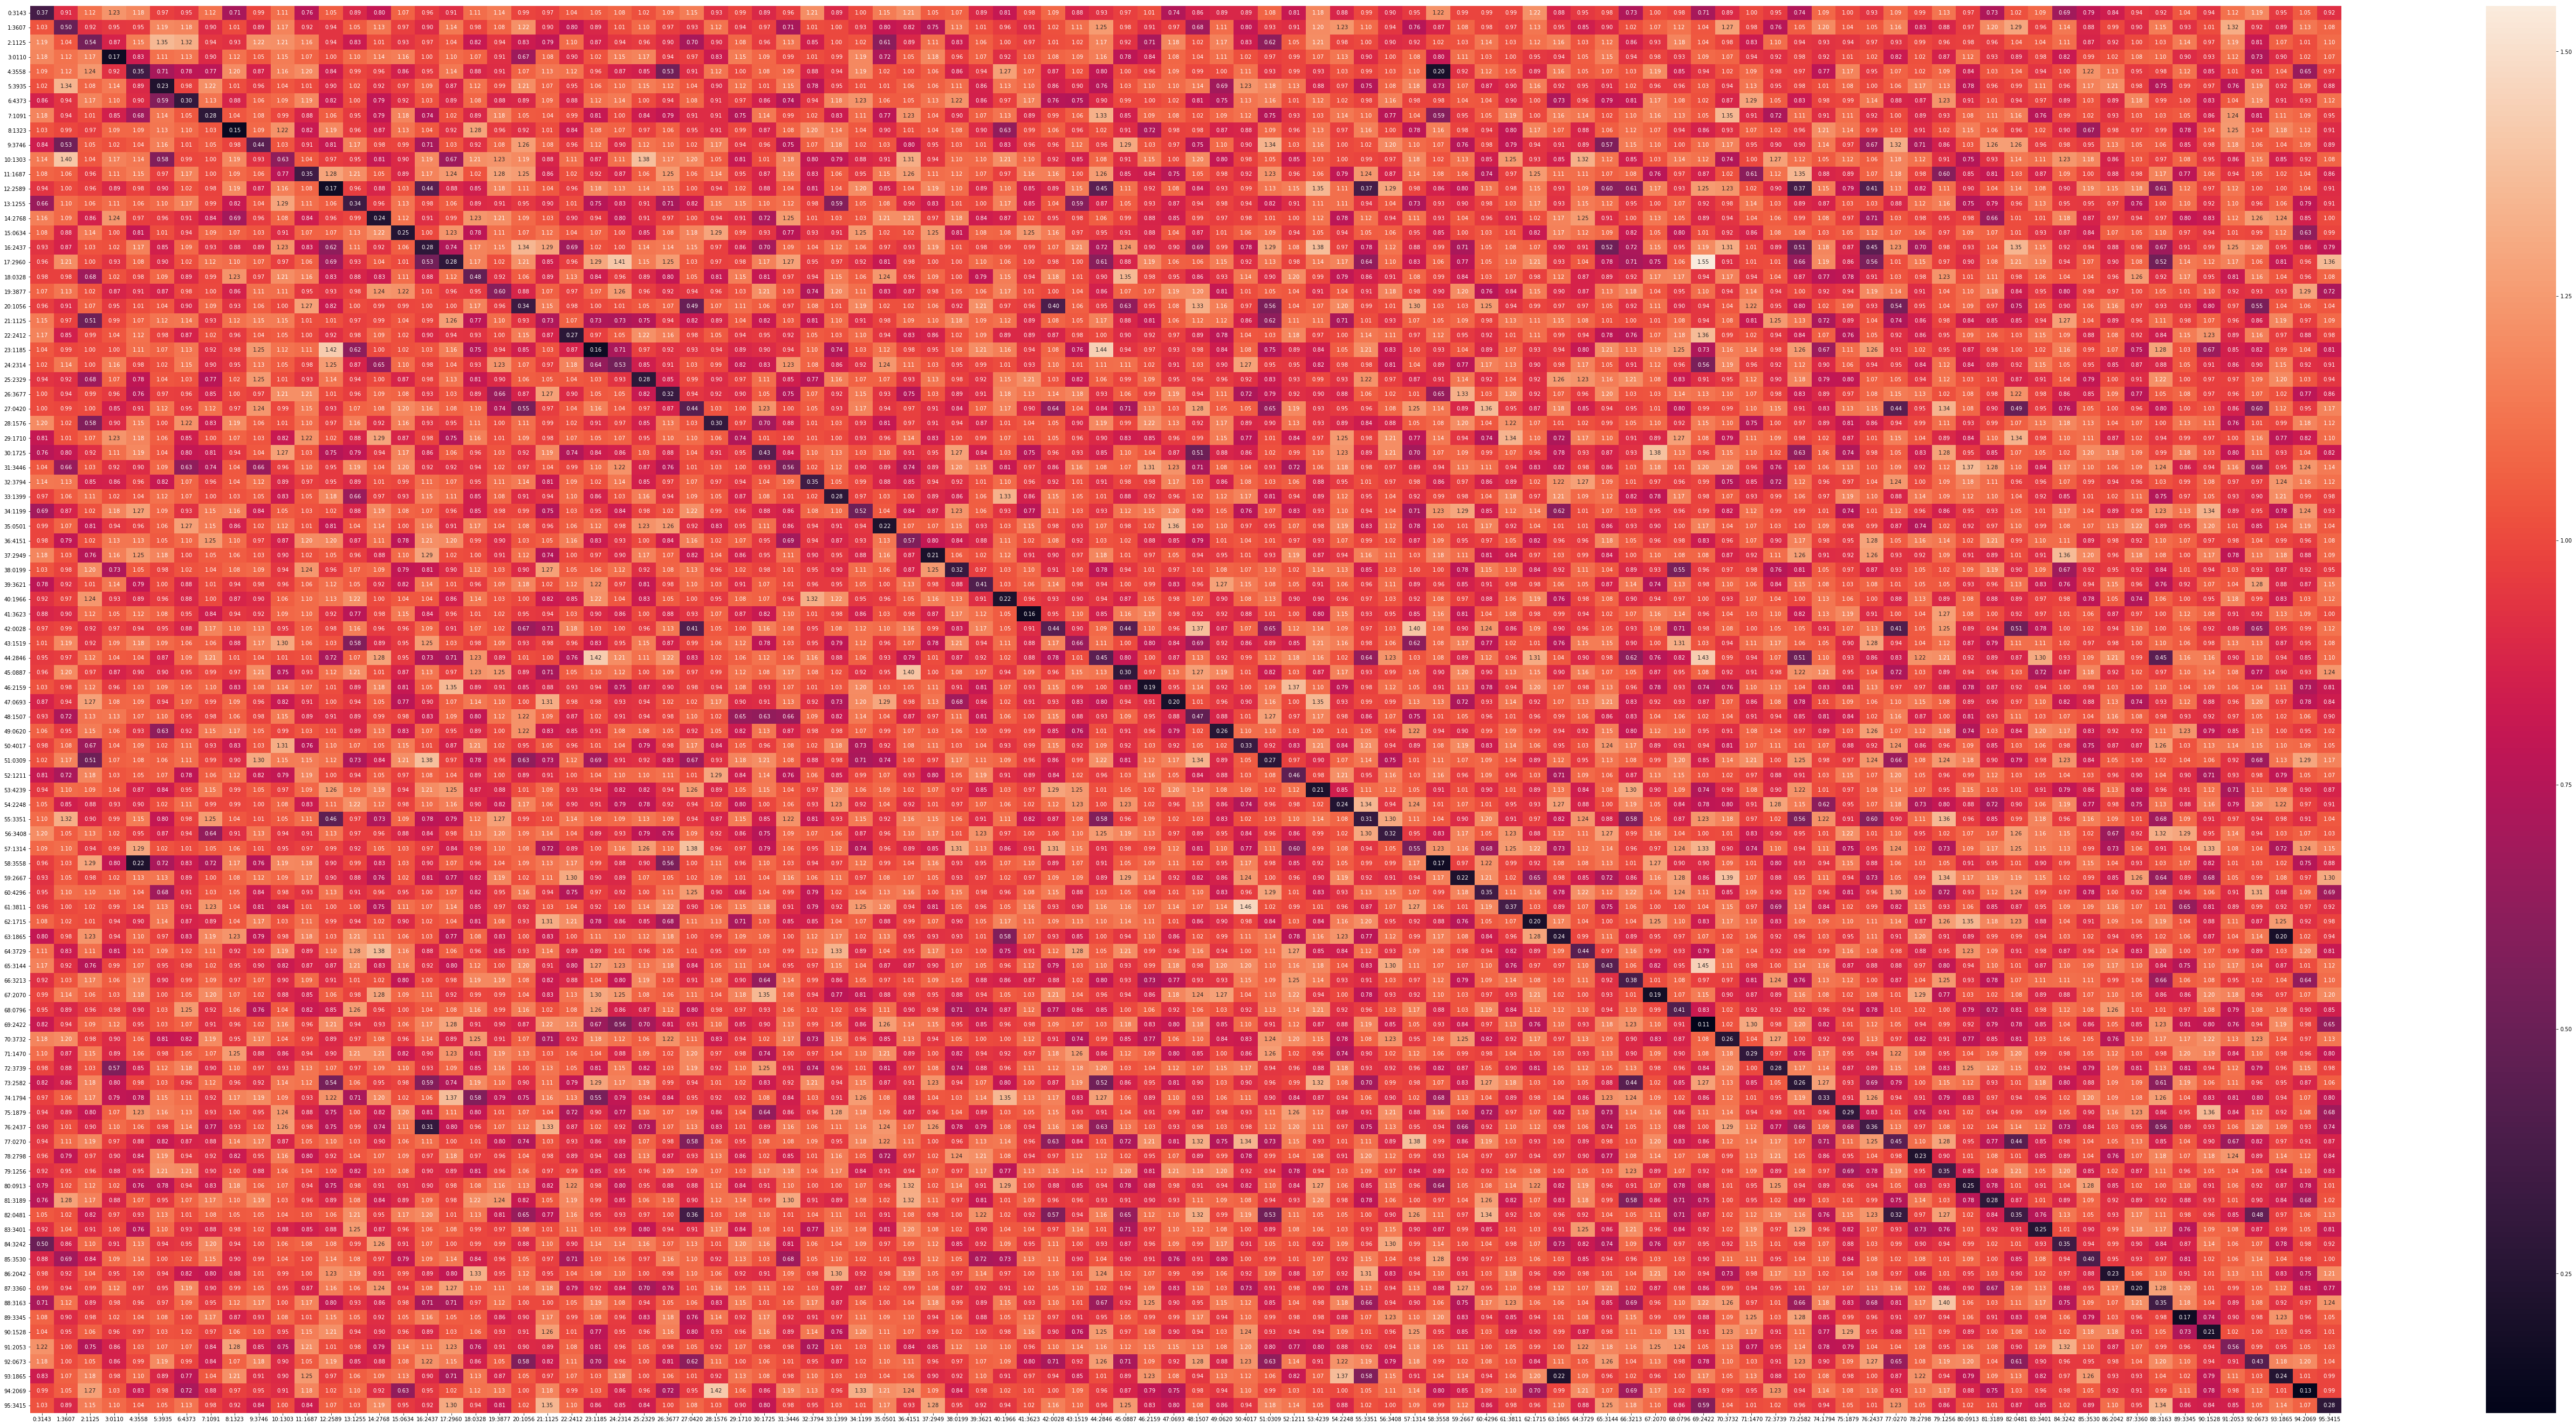

<Figure size 432x288 with 0 Axes>

In [76]:
cosine_distance_heatmap(best_model, next(iter(train_loader)))
_ = plt.savefig(f'cosine_distance_heatmap{best_epoch}_fold{fold}.png')

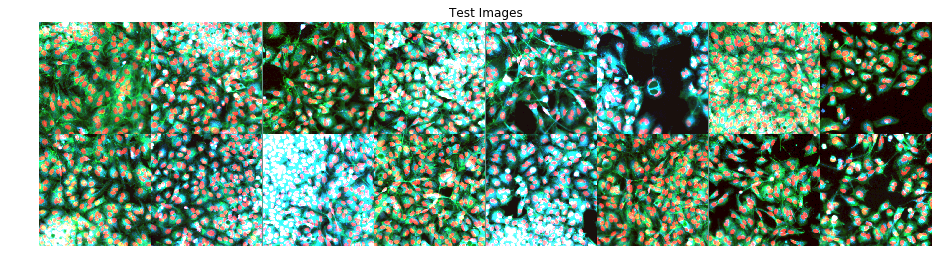

In [77]:
# Plot some test images
batch = next(iter(test_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Test Images")
_ = plt.imshow( normalize_channels(
    vutils.make_grid(batch[0][:16,::2], padding=2, normalize=False).cpu().numpy().transpose((1, 2, 0))
) )

- 분류
- 클래스 별 분류 prob 출력

In [78]:
# Classify
with torch.no_grad():
    y_pred = best_model(batch[0][:1].to(device))

# Print predictions
for idx in torch.topk(y_pred, k=10)[1].squeeze(0).tolist():
    prob = torch.softmax(y_pred, dim=-1)[0, idx].item()
    print('{label:<75} ({p:.8f}%)'.format(label=str(idx), p=prob*100))

del batch

855                                                                         (100.00000000%)
61                                                                          (0.00000401%)
1132                                                                        (0.00000058%)
468                                                                         (0.00000006%)
4105                                                                        (0.00000001%)
51                                                                          (0.00000000%)
278                                                                         (0.00000000%)
1012                                                                        (0.00000000%)
267                                                                         (0.00000000%)
3566                                                                        (0.00000000%)


#### Create submission and OOF predictions
- OOF Predictions(Out of Fold Prediction)
    - [참고1](https://daewonyoon.tistory.com/287)
    - K-fold인 경우, k 개 세트의 예측을 하나의 예측으로 만든 것

In [79]:
TTA = 9
def tta(sites):
    pred = []
    for site in sites:
        site = site.to(device)
        for i in range(TTA):
            x = tta9crop(site, i, resolution)
            pred.append(best_model(x).unsqueeze(0))
    # concat and calc mean softmax for submission
    pred = torch.cat(pred)
    pred = pred.reshape([pred.shape[0], pred.shape[1], n_classes // n_targets, n_targets]).max(dim=-2).values
    return pred[...,:1108].softmax(dim=-1).mean(dim=0).cpu()

In [80]:
from ignite.contrib.handlers import ProgressBar

def inference_update_with_tta(engine, batch):
    global preds, allpreds
    with torch.no_grad():
        sites = batch
        pred = tta(sites)
        allpreds = np.concatenate([allpreds, (-np.log(pred.numpy())).astype(np.float16)])
        preds += (torch.argmax(pred, dim=-1) % n_targets).tolist()

In [81]:
if create_sub:
    allpreds = np.empty([0,1108])
    preds = []

    inferencer = Engine(inference_update_with_tta)
    ProgressBar(desc="Inference").attach(inferencer)

    result_state = inferencer.run(valid_loader, max_epochs=1)

validation accuracy: 0.8102306920762287


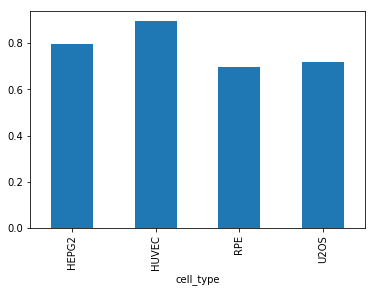

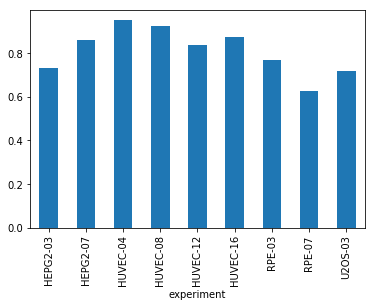

In [82]:
if create_sub:
    df_valid['pred'] = preds
    df_valid['acc']  = (df_valid.pred == df_valid.sirna).astype(int)

    print('validation accuracy:', df_valid.acc.mean())
    _ = df_valid.groupby('cell_type').acc.mean().plot(kind='bar'); plt.show()
    _ = df_valid.groupby('experiment').acc.mean().plot(kind='bar'); plt.show()

In [83]:
if create_sub:
    pd.DataFrame(allpreds, index=df_valid.id_code).to_pickle(f'df_valid_fold{fold}_log.pkl.gz')
    print(glob.glob('*.gz'))

['df_valid_fold1_log.pkl.gz']


In [84]:
if create_sub:
    allpreds = np.empty([0,1108])
    preds = []

    inferencer = Engine(inference_update_with_tta)
    ProgressBar(desc="Inference").attach(inferencer)

    result_state = inferencer.run(test_loader, max_epochs=1)

    pd.DataFrame(allpreds, index=df_test.id_code).to_pickle('df_test_log.pkl.gz')
    print(glob.glob('*.gz'))

['df_test_log.pkl.gz', 'df_valid_fold1_log.pkl.gz']


In [85]:
if create_sub:
    test_y = np.exp(-pd.read_pickle('df_test_log.pkl.gz').astype(np.float64)).fillna(0)
    valid_y = np.exp(-pd.read_pickle(f'df_valid_fold{fold}_log.pkl.gz').astype(np.float64)).fillna(0)
else: # recover last model
    test_y = np.exp(-pd.read_pickle(glob.glob(f'../input/*/df_test_log.pkl.gz')[0]).astype(np.float64)).fillna(0)
    valid_y = np.exp(-pd.read_pickle(glob.glob(f'../input/*/df_valid_fold{fold}_log.pkl.gz')[0]).astype(np.float64)).fillna(0)
    
# normalise across siRNA's (each siRNA is equally likely to appear)
test_y = test_y / test_y.sum(axis=0)
valid_y = valid_y / valid_y.sum(axis=0)

df_valid['pred'] = valid_y.values.argmax(axis=1)
df_valid['acc']  = (df_valid.pred == df_valid.sirna).astype(int)

print('validation accuracy (norm):', df_valid.acc.mean())
# _ = df_valid.groupby('cell_type').acc.mean().plot(kind='bar'); plt.show()
# _ = df_valid.groupby('experiment').acc.mean().plot(kind='bar'); plt.show()

validation accuracy (norm): 0.8229689067201604


In [86]:
## remove siRNA in the wrong plate and normalise again (both horizontally and vertically)
preds = remove_leaked_sirna(df_valid.set_index('id_code'), valid_y.copy())

best_score = -1
bestpreds = None
scores = []
for k in tqdm(range(10)):
    preds, newscore, sirna_preds = normalize_both_ways(preds, df_valid.sirna.values)
    print(f'Newscore:{newscore} Iter:{k}')
    scores.append(newscore)
    if newscore > best_score:
        best_score = newscore
        best_iter = k
        bestpreds = sirna_preds
#     elif device == 'cuda': break  ## stop to save GPU $$$

Newscore:0.967703109327984 Iter:0
Newscore:0.9674022066198595 Iter:1
Newscore:0.9689067201604814 Iter:2
Newscore:0.9683049147442327 Iter:3
Newscore:0.9685055165496489 Iter:4
Newscore:0.9687061183550651 Iter:5
Newscore:0.9688064192577733 Iter:6
Newscore:0.9691073219658977 Iter:7
Newscore:0.9697091273821464 Iter:8
Newscore:0.9696088264794384 Iter:9



(0.9697091273821464, 8)

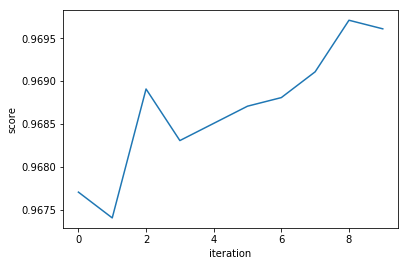

In [87]:
plt.plot(range(len(scores)), scores)
plt.ylabel("score")
plt.xlabel("iteration")

best_score, best_iter

validation accuracy (norm): 0.9697091273821464


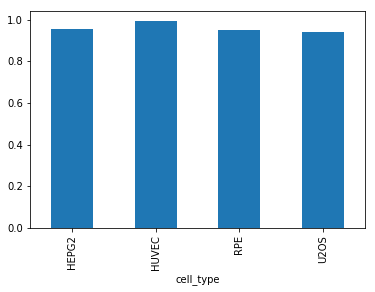

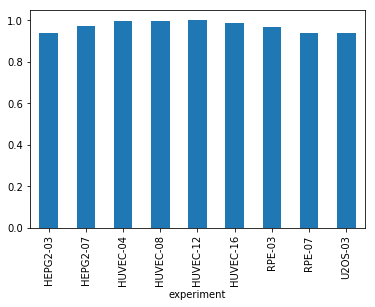

In [88]:
df_valid['pred'] = bestpreds
df_valid['acc'] = (df_valid.pred == df_valid.sirna).astype(int)

print('validation accuracy (norm):', df_valid.acc.mean())
_ = df_valid.groupby('cell_type').acc.mean().plot(kind='bar'); plt.show()
_ = df_valid.groupby('experiment').acc.mean().plot(kind='bar'); plt.show()

In [89]:
test_preds = remove_leaked_sirna(df_test.set_index('id_code'), test_y.copy())

for i in tqdm(range(best_iter+1)):
    test_preds, _, _ = normalize_both_ways(test_preds)

## assign the most likely unique treatment to each well
preds = assign_sirna(test_preds)

Finally, the submission csv:

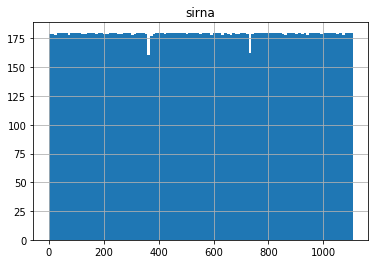

In [90]:
if create_sub:
    submission = pd.DataFrame({'id_code': pd.read_csv(path_data+'/sample_submission.csv').id_code.values,
                               'sirna':   np.squeeze(preds).astype(int)})
    submission.to_csv('submission.csv', index=False)
    submission.hist(bins=111)
    submission.head()

In [91]:
if not is_interactive():
    # clean up folders
    !rm -rf apex /tmp/*
    !ls -lh *

-rw-r--r-- 1 root root 103K Sep 25 19:53 __notebook__.ipynb
-rw-r--r-- 1 root root  488 Sep 26 02:01 __output__.json
-rw-r--r-- 1 root root 1.3K Sep 26 01:48 cosine_distance_heatmap1_fold1.png
-rw-r--r-- 1 root root  43M Sep 26 02:31 df_test_log.pkl.gz
-rw-r--r-- 1 root root  22M Sep 26 02:02 df_valid_fold1_log.pkl.gz
-rw------- 1 root root  37M Sep 26 01:47 fold1h4r3_1_0.6600802.pth
-rw-r--r-- 1 root root  56K Sep 26 01:47 loss_history1_fold1.png
-rw-r--r-- 1 root root 359K Sep 26 02:37 submission.csv

log:
total 160K
-rw-r--r-- 1 root root 156K Sep 26 01:47 events.out.tfevents.1569441936.60ddcff70ff0
